Juan Andres Galicia 20298
 
Oscar Méndez 20402

# Proyecto Final

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import randint, uniform
import swifter

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils.class_weight import compute_class_weight
import xgboost as xgb

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM, concatenate, Dense
from tensorflow.keras.models import Model
from keras import backend as K
from keras.preprocessing.text import Tokenizer, tokenizer_from_json
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Concatenate, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint, EarlyStopping

import string
import re
import spacy
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from spellchecker import SpellChecker
from textatistic import Textatistic
from language_tool_python import LanguageTool

#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')
nlp = spacy.load("en_core_web_sm")
spell = SpellChecker()
tool = LanguageTool('en-US')
lemmatizer = WordNetLemmatizer()
STOP_WORDS = stopwords.words('english')
PUNCT_MARKS = list(string.punctuation)

## Análisis Exploratorio

In [2]:
summaries = pd.read_csv('summaries_train.csv')
summaries.head()

student_id prompt_id                                               text  \
0  000e8c3c7ddb    814d6b  The third wave was an experimentto see how peo...   
1  0020ae56ffbf    ebad26  They would rub it up with soda to make the sme...   
2  004e978e639e    3b9047  In Egypt, there were many occupations and soci...   
3  005ab0199905    3b9047  The highest class was Pharaohs these people we...   
4  0070c9e7af47    814d6b  The Third Wave developed  rapidly because the ...   

    content   wording  
0  0.205683  0.380538  
1 -0.548304  0.506755  
2  3.128928  4.231226  
3 -0.210614 -0.471415  
4  3.272894  3.219757

In [3]:
prompts = pd.read_csv('prompts_train.csv')
prompts.head()

prompt_id                                    prompt_question  \
0    39c16e  Summarize at least 3 elements of an ideal trag...   
1    3b9047  In complete sentences, summarize the structure...   
2    814d6b  Summarize how the Third Wave developed over su...   
3    ebad26  Summarize the various ways the factory would u...   

                prompt_title  \
0                 On Tragedy   
1  Egyptian Social Structure   
2             The Third Wave   
3    Excerpt from The Jungle   

                                         prompt_text  
0  Chapter 13 \r\nAs the sequel to what has alrea...  
1  Egyptian society was structured like a pyramid...  
2  Background \r\nThe Third Wave experiment took ...  
3  With one member trimming beef in a cannery, an...

In [4]:
df = summaries.merge(prompts, on='prompt_id', how='left')
df.head()

student_id prompt_id                                               text  \
0  000e8c3c7ddb    814d6b  The third wave was an experimentto see how peo...   
1  0020ae56ffbf    ebad26  They would rub it up with soda to make the sme...   
2  004e978e639e    3b9047  In Egypt, there were many occupations and soci...   
3  005ab0199905    3b9047  The highest class was Pharaohs these people we...   
4  0070c9e7af47    814d6b  The Third Wave developed  rapidly because the ...   

    content   wording                                    prompt_question  \
0  0.205683  0.380538  Summarize how the Third Wave developed over su...   
1 -0.548304  0.506755  Summarize the various ways the factory would u...   
2  3.128928  4.231226  In complete sentences, summarize the structure...   
3 -0.210614 -0.471415  In complete sentences, summarize the structure...   
4  3.272894  3.219757  Summarize how the Third Wave developed over su...   

                prompt_title  \
0             The Third Wave   
1    Excerpt from The Jungle   
2  Egyptian Social Structure   
3  Egyptian Social Structure   
4             The Third Wave   

                                         prompt_text  
0  Background \r\nThe Third Wave experiment took ...  
1  With one member trimming beef in a cannery, an...  
2  Egyptian society was structured like a pyramid...  
3  Egyptian society was structured like a pyramid...  
4  Background \r\nThe Third Wave experiment took ...

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7165 entries, 0 to 7164
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   student_id       7165 non-null   object 
 1   prompt_id        7165 non-null   object 
 2   text             7165 non-null   object 
 3   content          7165 non-null   float64
 4   wording          7165 non-null   float64
 5   prompt_question  7165 non-null   object 
 6   prompt_title     7165 non-null   object 
 7   prompt_text      7165 non-null   object 
dtypes: float64(2), object(6)
memory usage: 503.8+ KB


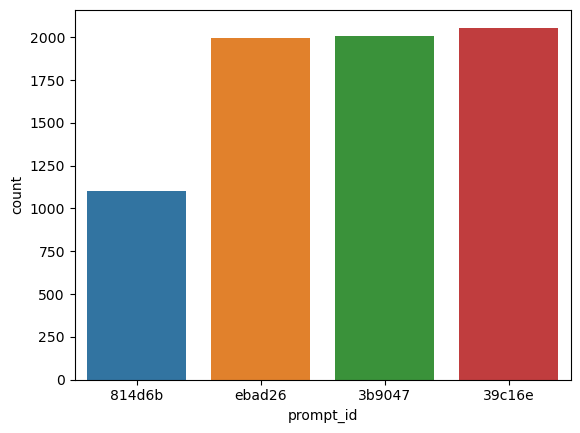

In [6]:
sns.countplot(x='prompt_id', data=df)
plt.show()

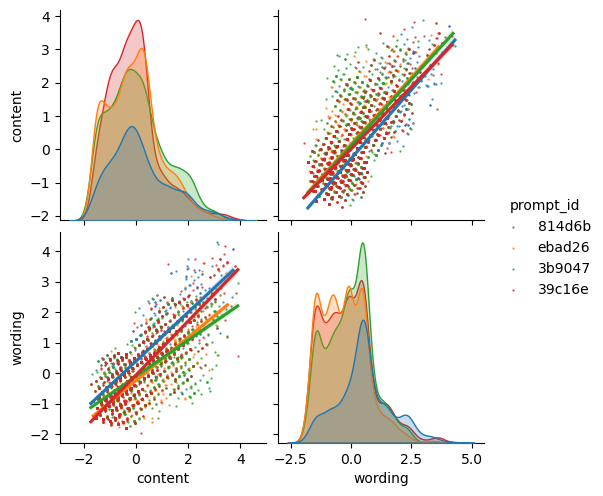

In [7]:
sns.pairplot(vars=['content', 'wording'], hue='prompt_id', data=df, diag_kind='kde', kind='reg', plot_kws={'scatter_kws': {'alpha': 0.8, 's': 0.4}})
plt.show()

## Feature Engineering

In [8]:
def spelling_errors(text):
    words = text.split()
    misspelled = spell.unknown(words)
    return len(misspelled)

def grammar_errors(text):
    matches = tool.check(text)
    return len(matches)

def punctuation_marks(text):
    return sum([1 for char in text if char in PUNCT_MARKS])

contractions = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he's": "he is",
    "how'd": "how did",
    "how'll": "how will",
    "how's": "how is",
    "I'd": "I would",
    "I'll": "I will",
    "I'm": "I am",
    "I've": "I have",
    "isn't": "is not",
    "it'd": "it would",
    "it'll": "it will",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "might've": "might have",
    "mightn't": "might not",
    "must've": "must have",
    "mustn't": "must not",
    "needn't": "need not",
    "oughtn't": "ought not",
    "shan't": "shall not",
    "she'd": "she would",
    "she'll": "she will",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "that'd": "that would",
    "that's": "that is",
    "there's": "there is",
    "they'd": "they would",
    "they'll": "they will",
    "they're": "they are",
    "they've": "they have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'll": "we will",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what's": "what is",
    "where's": "where is",
    "who'll": "who will",
    "who's": "who is",
    "won't": "will not",
    "wouldn't": "would not",
    "you'd": "you would",
    "you'll": "you will",
    "you're": "you are",
    "you've": "you have"
}

def handle_contractions(text):
    words = word_tokenize(text)
    words = [contractions[word] if word in contractions else word for word in words]
    return ' '.join(words)

def spell_correction(text):
    words = word_tokenize(text)
    corrected_words = [spell.correction(word) if spell.correction(word) is not None else word for word in words]
    return ' '.join(corrected_words)

def end_sentence(text):
    if text[-1] not in ['!', '?', '.']:
        return text + '.'
    return text

def readability_features(text):
    s = Textatistic(text)
    return pd.Series([s.sent_count, s.word_count, s.sybl_count, s.char_count, s.polysyblword_count, s.dalechall_score,
                      s.flesch_score, s.fleschkincaid_score, s.gunningfog_score, s.smog_score])

def avg_word_length(text):
    words = text.split()
    word_lengths = [len(word) for word in words]
    avg_word_length = sum(word_lengths)/len(words)
    return(avg_word_length)

def stop_words(text):
    words = text.split()
    return sum(1 for word in words if word.lower() in STOP_WORDS)

def lexical_types(text):
    words = word_tokenize(text)
    lexical_types = set(words)
    return len(lexical_types)

def syntatic_complexity_features(text):
    doc = nlp(text)
    total_tokens = len(doc)
    num_clauses = len([token for token in doc if token.dep_ == "ROOT"])
    num_sub_clauses = len([token for token in doc if token.dep_ == "acl" or token.dep_ == "advcl"])
    num_verb_phrases = len([chunk for chunk in doc.noun_chunks if chunk.root.pos_ == "VERB"])
    num_complex_noun_phrases = len([chunk for chunk in doc.noun_chunks if len(chunk) > 1])

    return pd.Series([num_clauses / total_tokens, num_sub_clauses / total_tokens, num_verb_phrases / total_tokens,
                      num_complex_noun_phrases / total_tokens])

def remove_stop_words(text):
    removed_stop_words = ' '.join([word for word in text.split() if word not in STOP_WORDS])
    return removed_stop_words

def lemmatize_text(text):
    lemmatized_words = [lemmatizer.lemmatize(word) for word in text.split()]
    lemmatized_text = ' '.join(lemmatized_words)
    return lemmatized_text

def feature_extraction_text(df, col, suffix, prompts=False):
    data = df.copy()
    
    # Fase 1
    if col == 'text':
        data['spelling_errors_' + suffix] = data[col].swifter.apply(spelling_errors)
        data['grammar_errors_' + suffix] = data[col].swifter.apply(grammar_errors)
        data['punctuation_marks_' + suffix] = data[col].apply(punctuation_marks)
    
    # Fase 2
    data[suffix + '_lemmatized'] = data[col].str.lower()
    data[suffix + '_lemmatized'] = data[suffix + '_lemmatized'].swifter.apply(handle_contractions)
    
    if col == 'text':
        data[suffix + '_lemmatized'] = data[suffix + '_lemmatized'].swifter.apply(spell_correction)
        
    data[suffix + '_lemmatized'] = data[suffix + '_lemmatized'].apply(end_sentence)
    
    # Fase 3
    data['text_length_' + suffix] = data[suffix + '_lemmatized'].apply(len)
    
    data[['sent_count_' + suffix, 'word_count_' + suffix, 'sybl_count_' + suffix, 
          'char_count_' + suffix, 'polysyblword_count_' + suffix, 'dalechall_score_' + suffix, 
          'flesch_score_' + suffix, 'fleschkincaid_score_' + suffix, 'gunningfog_score_' + suffix,
          'smog_score_' + suffix]] = data[suffix + '_lemmatized'].swifter.apply(readability_features)
    
    data['stop_words_' + suffix] = data[suffix + '_lemmatized'].apply(stop_words)
    
    data['lexical_types_' + suffix] = data[suffix + '_lemmatized'].swifter.apply(lexical_types)
    
    data[['clauses_prop_' + suffix, 'sub_clauses_prop_' + suffix, 'verb_phrases_prop_' + suffix,
          'noun_phrases_prop_' + suffix]] = data[suffix + '_lemmatized'].swifter.apply(syntatic_complexity_features)
    
    data['chars_per_word_' + suffix] = data['char_count_' + suffix] / data['word_count_' + suffix]
    data['words_per_sentence_' + suffix] = data['word_count_' + suffix] / data['sent_count_' + suffix]
    data['sybl_per_sentence_' + suffix] = data['sybl_count_' + suffix] / data['sent_count_' + suffix] 
    
    # Fase 4
    data[suffix + '_lemmatized'] = data[suffix + '_lemmatized'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))
    data[suffix + '_lemmatized'] = data[suffix + '_lemmatized'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
    data[suffix + '_lemmatized'] = data[suffix + '_lemmatized'].swifter.apply(lemmatize_text)
    data[suffix + '_no_stopwords'] = data[suffix + '_lemmatized'].apply(remove_stop_words)
    
    return data

def fit_transform_tfidf(dataframe):
    tfidf_dict = {}

    for prompt_id in dataframe['prompt_id'].unique():
        prompt_text = dataframe[dataframe['prompt_id'] == prompt_id]['prompt_text'].iloc[[0]]

        vectorizer = TfidfVectorizer()
        
        tfidf_matrix = vectorizer.fit_transform(prompt_text)

        tfidf_dict[prompt_id] = {
            'vectorizer': vectorizer,
            'tfidf_vector': tfidf_matrix.toarray().flatten()
        }

    return tfidf_dict

def calculate_word_distance(row, tfidf_dict, text_column):
    tfidf_essay = tfidf_dict[row['prompt_id']]['vectorizer'].transform([row[text_column]])
    differences = tfidf_dict[row['prompt_id']]['tfidf_vector'] - tfidf_essay.toarray().flatten()
    return 1 / np.abs(differences).sum()

def feature_extraction_general(df):
    data = df.copy()
    
    ratio_columns = [
        'dalechall_score_', 'flesch_score_', 'fleschkincaid_score_', 'gunningfog_score_', 'smog_score_',
        'clauses_prop_', 'sub_clauses_prop_', 'verb_phrases_prop_', 'noun_phrases_prop_',
        'chars_per_word_', 'words_per_sentence_', 'sybl_per_sentence_'
    ]
    
    for col in ratio_columns:
        data[col + 'ratio'] = data[col + 'essay'] / data[col + 'prompt']
    
    tfidf_dict = fit_transform_tfidf(data)
    data['words_similarity'] = data.swifter.apply(
        calculate_word_distance,
        tfidf_dict=tfidf_dict,
        text_column='essay_no_stopwords',
        axis=1
    )
    
    return data

In [9]:
#df = feature_extraction_text(df, 'text', 'essay')
#df = feature_extraction_text(df, 'prompt_text', 'prompt')
#df = feature_extraction_text(df, 'prompt_question', 'question')
#df = feature_extraction_general(df)
#df.to_csv('train_features.csv', index=False)

## Preparacion del Modelo

In [10]:
def regression_report(y_true, y_pred, name):
    print(name)
    print('std =', np.std(y_true))
    print('rmse =', np.sqrt(mean_squared_error(y_true, y_pred)))
    print('r2 =', r2_score(y_true, y_pred), '\n')

In [11]:
df = pd.read_csv('train_features.csv')
df.head()

student_id prompt_id                                               text  \
0  000e8c3c7ddb    814d6b  The third wave was an experimentto see how peo...   
1  0020ae56ffbf    ebad26  They would rub it up with soda to make the sme...   
2  004e978e639e    3b9047  In Egypt, there were many occupations and soci...   
3  005ab0199905    3b9047  The highest class was Pharaohs these people we...   
4  0070c9e7af47    814d6b  The Third Wave developed  rapidly because the ...   

    content   wording                                    prompt_question  \
0  0.205683  0.380538  Summarize how the Third Wave developed over su...   
1 -0.548304  0.506755  Summarize the various ways the factory would u...   
2  3.128928  4.231226  In complete sentences, summarize the structure...   
3 -0.210614 -0.471415  In complete sentences, summarize the structure...   
4  3.272894  3.219757  Summarize how the Third Wave developed over su...   

                prompt_title  \
0             The Third Wave   
1    Excerpt from The Jungle   
2  Egyptian Social Structure   
3  Egyptian Social Structure   
4             The Third Wave   

                                         prompt_text  spelling_errors_essay  \
0  Background \r\nThe Third Wave experiment took ...                      5   
1  With one member trimming beef in a cannery, an...                      2   
2  Egyptian society was structured like a pyramid...                     32   
3  Egyptian society was structured like a pyramid...                      5   
4  Background \r\nThe Third Wave experiment took ...                     29   

   grammar_errors_essay  ...  gunningfog_score_ratio smog_score_ratio  \
0                     3  ...                0.801371         0.909527   
1                     3  ...                0.616276         0.349426   
2                     2  ...                1.255015         1.022929   
3                     3  ...                1.111391         1.022929   
4                    15  ...                0.740977         0.846515   

   clauses_prop_ratio  sub_clauses_prop_ratio  verb_phrases_prop_ratio  \
0            1.576331                2.927473                      NaN   
1            1.610182                1.548252                      NaN   
2            0.634366                0.930403                      NaN   
3            0.995298                0.000000                      NaN   
4            1.539122                0.816677                      NaN   

   noun_phrases_prop_ratio  chars_per_word_ratio  words_per_sentence_ratio  \
0                 0.758974              0.965068                  0.673895   
1                 0.999226              0.880900                  0.657230   
2                 0.759513              0.943478                  1.593058   
3                 1.564039              1.072084                  0.493716   
4                 0.926323              0.990123                  0.672317   

   sybl_per_sentence_ratio  words_similarity  
0                 0.668706          0.106910  
1                 0.583910          0.096492  
2                 1.531459          0.085946  
3                 0.544846          0.098658  
4                 0.667582          0.103167  

[5 rows x 90 columns]

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7165 entries, 0 to 7164
Data columns (total 90 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   student_id                    7165 non-null   object 
 1   prompt_id                     7165 non-null   object 
 2   text                          7165 non-null   object 
 3   content                       7165 non-null   float64
 4   wording                       7165 non-null   float64
 5   prompt_question               7165 non-null   object 
 6   prompt_title                  7165 non-null   object 
 7   prompt_text                   7165 non-null   object 
 8   spelling_errors_essay         7165 non-null   int64  
 9   grammar_errors_essay          7165 non-null   int64  
 10  punctuation_marks_essay       7165 non-null   int64  
 11  essay_lemmatized              7165 non-null   object 
 12  text_length_essay             7165 non-null   int64  
 13  sen

Separamos el dataset del train y del validation

In [13]:
X = df.drop([
    'student_id', 'prompt_id', 'prompt_title', 'content', 'wording'
], axis=1)

Y = df[['content', 'wording']]

In [14]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=24)

In [15]:
text_cols = [
    'text', 'essay_lemmatized', 'essay_no_stopwords',
    'prompt_text', 'prompt_lemmatized', 'prompt_no_stopwords',
    'prompt_question', 'question_lemmatized', 'question_no_stopwords'
]

X_train_features = X_train.drop(text_cols, axis=1)

X_val_features = X_val.drop(text_cols, axis=1)

Entrenamos nuestro primer modelo con todas las features.

In [16]:
xgb_model_1 = xgb.XGBRegressor(
    objective='reg:squarederror',
    seed=24,
    learning_rate=0.05,
    min_child_weight=100,
    max_depth=20,
    n_estimators=100
)

multi_xgb_model_1 = MultiOutputRegressor(xgb_model_1).fit(X_train_features, Y_train)

multi_xgb_model_1.fit(X_train_features, Y_train)
predictions_xgb = multi_xgb_model_1.predict(X_val_features)

In [17]:
regression_report(Y_train['content'], multi_xgb_model_1.predict(X_train_features)[:, 0], 'CONTENT TRAIN')
regression_report(Y_val['content'], predictions_xgb[:, 0], 'CONTENT TEST')

regression_report(Y_train['wording'], multi_xgb_model_1.predict(X_train_features)[:, 1], 'WORDING TRAIN')
regression_report(Y_val['wording'], predictions_xgb[:, 1], 'WORDING TEST')

CONTENT TRAIN
std = 1.0487952988077796
rmse = 0.39389386301925006
r2 = 0.8589487416635762 

CONTENT TEST
std = 1.0220265405010216
rmse = 0.4607549811780617
r2 = 0.796756937542155 

WORDING TRAIN
std = 1.04289755999341
rmse = 0.5229289971289345
r2 = 0.7485786542153607 

WORDING TEST
std = 1.0075341042027464
rmse = 0.6174299774518763
r2 = 0.6244602508090671 



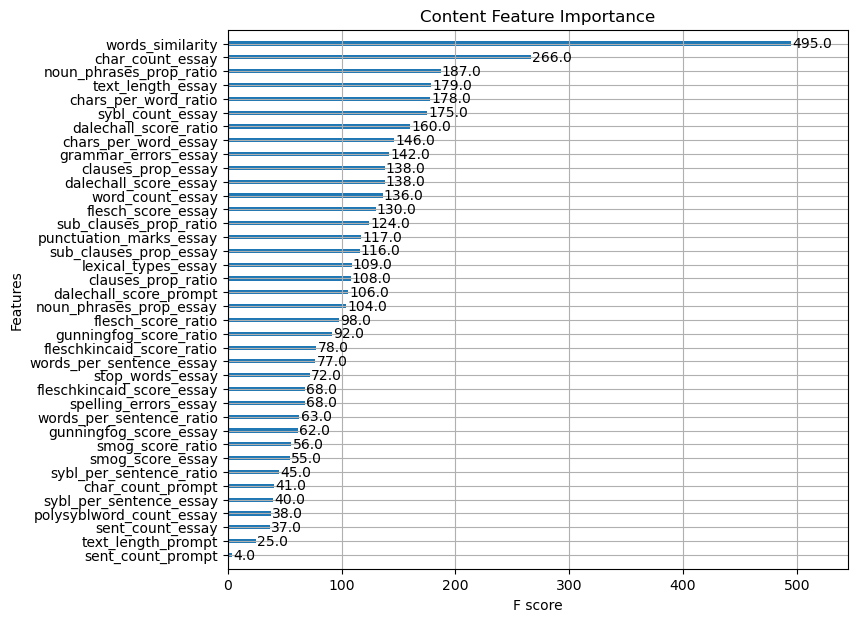

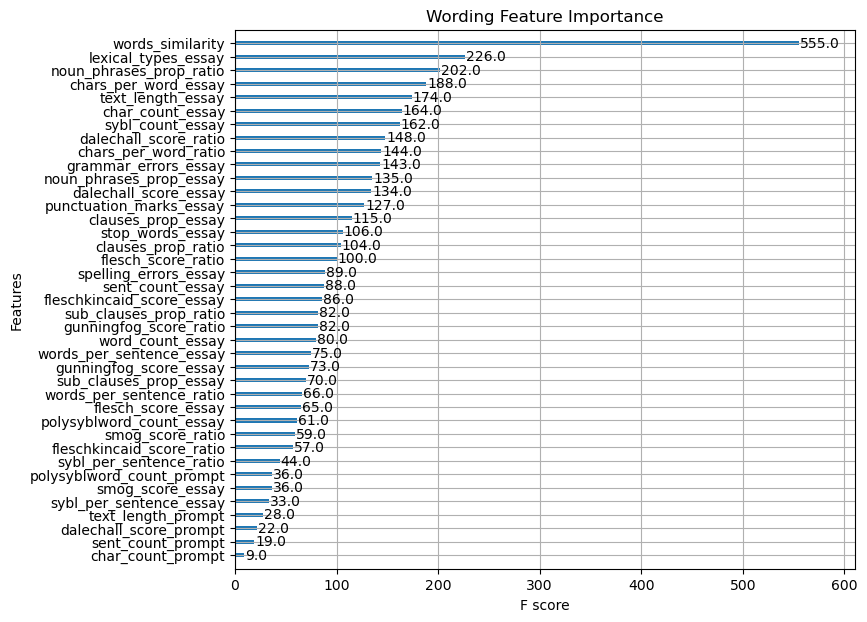

In [18]:
fig, ax = plt.subplots(figsize=(8, 7))
xgb.plot_importance(multi_xgb_model_1.estimators_[0], height=0.3, title='Content Feature Importance', ax=ax)
plt.show()

fig, ax = plt.subplots(figsize=(8, 7))
xgb.plot_importance(multi_xgb_model_1.estimators_[1], height=0.3, title='Wording Feature Importance', ax=ax)
plt.show()

Seleccionamos solamente las features que aportan suficiente información al modelo

In [19]:
content_importances = multi_xgb_model_1.estimators_[0].get_booster().get_score(importance_type='weight')
wording_importances = multi_xgb_model_1.estimators_[1].get_booster().get_score(importance_type='weight')

features_used = set(content_importances.keys()).union(set(wording_importances.keys()))
features_to_keep = features_used - {'sent_count_pompt', 'char_count_prompt', 'text_length_prompt', 'polysyblword_count_prompt'}

print("Total selected features:", len(features_to_keep))

xgb_model_2 = xgb.XGBRegressor(
    objective='reg:squarederror',
    seed=24,
    learning_rate=0.05,
    min_child_weight=100,
    max_depth=20,
    n_estimators=100
)

multi_xgb_model_2 = MultiOutputRegressor(xgb_model_2).fit(X_train_features, Y_train)

multi_xgb_model_2.fit(X_train_features[features_to_keep], Y_train)
predictions_xgb = multi_xgb_model_2.predict(X_val_features[features_to_keep])

Total selected features: 36


In [20]:
regression_report(Y_train['content'], multi_xgb_model_2.predict(X_train_features[features_to_keep])[:, 0], 'CONTENT TRAIN')
regression_report(Y_val['content'], predictions_xgb[:, 0], 'CONTENT TEST')

regression_report(Y_train['wording'], multi_xgb_model_2.predict(X_train_features[features_to_keep])[:, 1], 'WORDING TRAIN')
regression_report(Y_val['wording'], predictions_xgb[:, 1], 'WORDING TEST')

CONTENT TRAIN
std = 1.0487952988077796
rmse = 0.39376813338141836
r2 = 0.859038773496625 

CONTENT TEST
std = 1.0220265405010216
rmse = 0.46118528871714454
r2 = 0.7963771354153164 

WORDING TRAIN
std = 1.04289755999341
rmse = 0.5234339458917947
r2 = 0.748092866687543 

WORDING TEST
std = 1.0075341042027464
rmse = 0.6178468885714508
r2 = 0.6239529234593872 



## Incidencia de Variables

In [21]:
def plot_numeric_features(df, features, target):
    df_plot = df.copy()

    for col in features:
        df_plot[col] = pd.qcut(df[col], q=4, labels=False)

        sns.boxplot(
            x=target,
            y=col,
            orient='h',
            data=df_plot,
            showfliers=False
        )

        plt.title(col)
        plt.show()

13


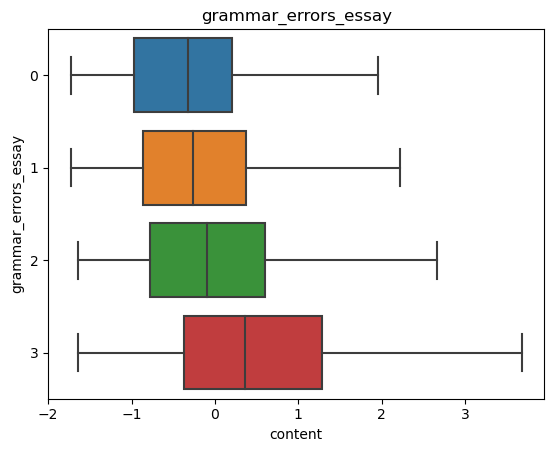

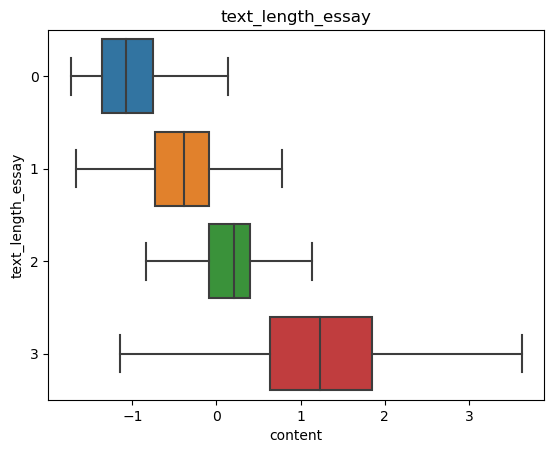

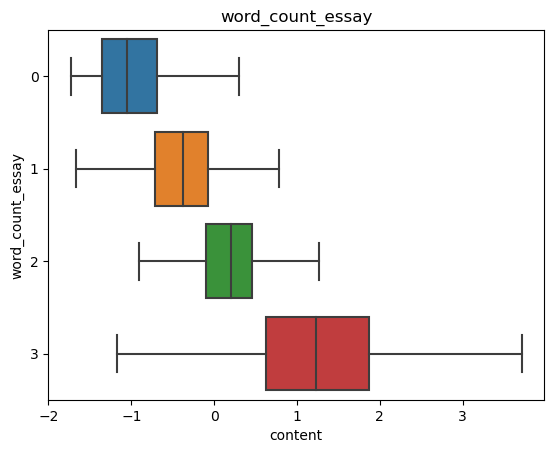

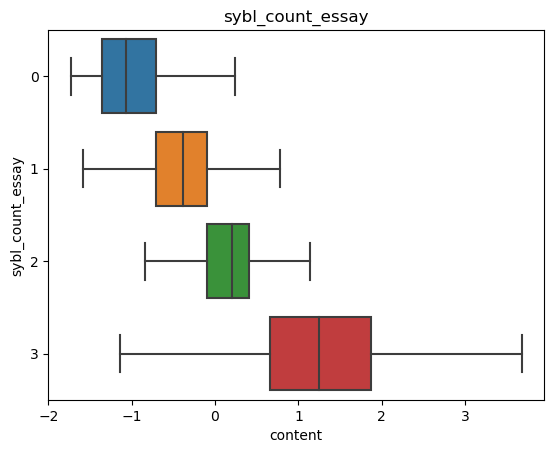

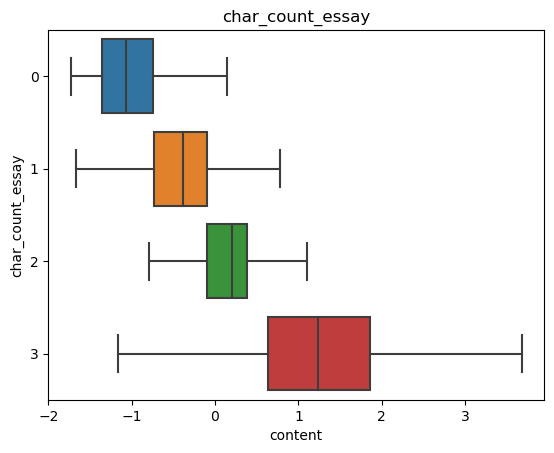

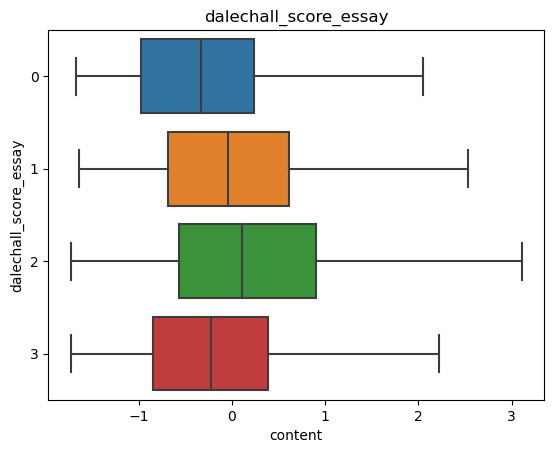

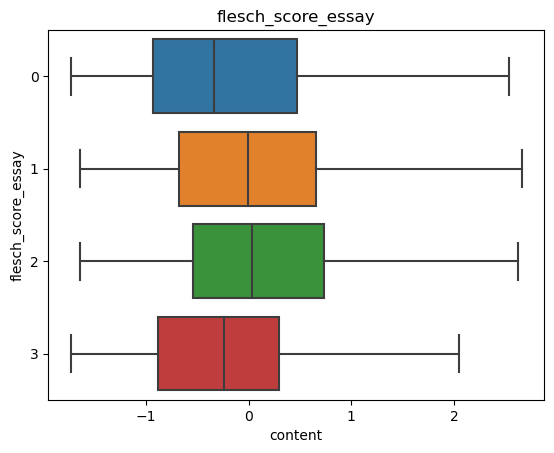

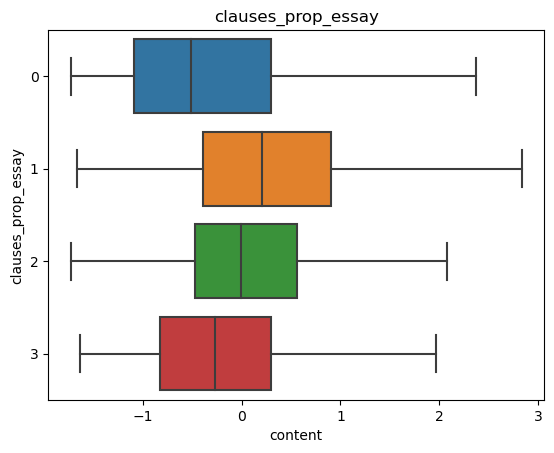

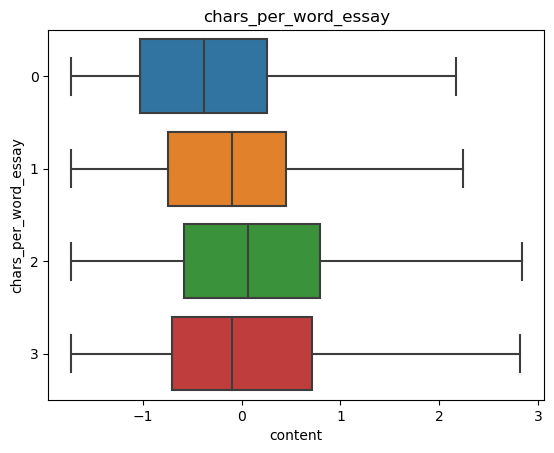

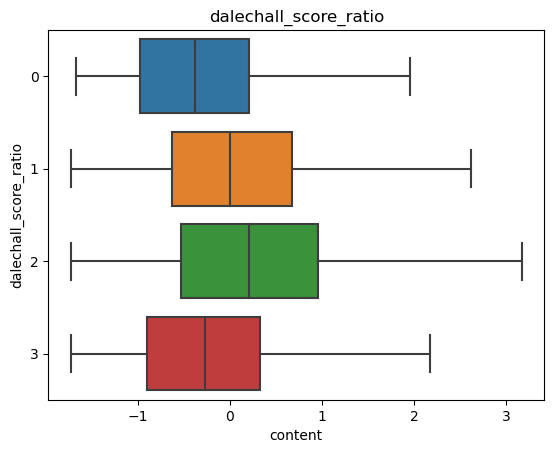

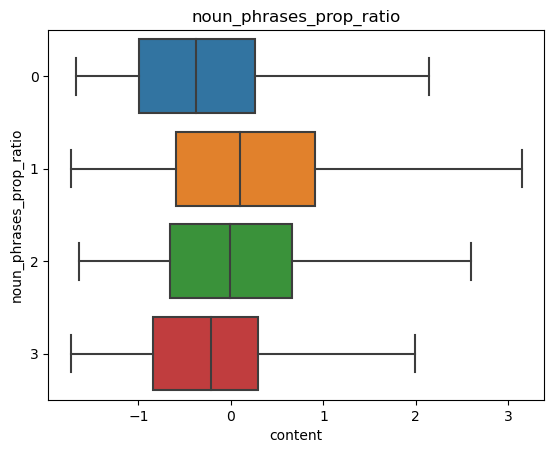

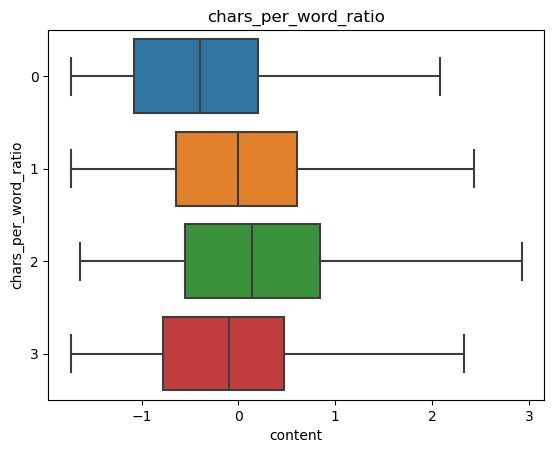

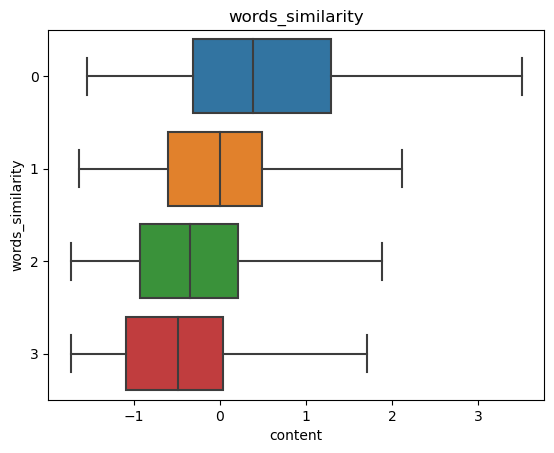

In [22]:
features_to_plot = [feature for feature, importance in content_importances.items() if importance >= 130]
print(len(features_to_plot))

plot_numeric_features(df, features_to_plot, 'content')

13


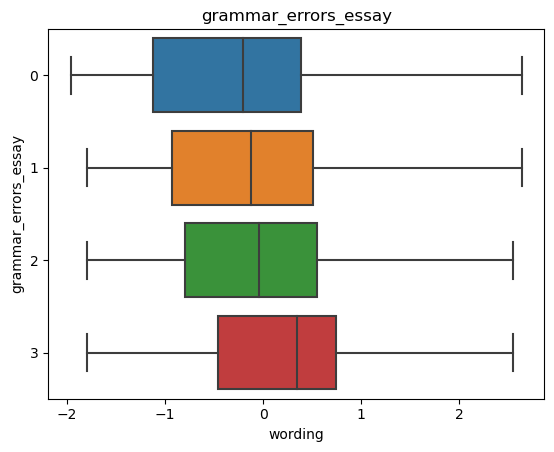

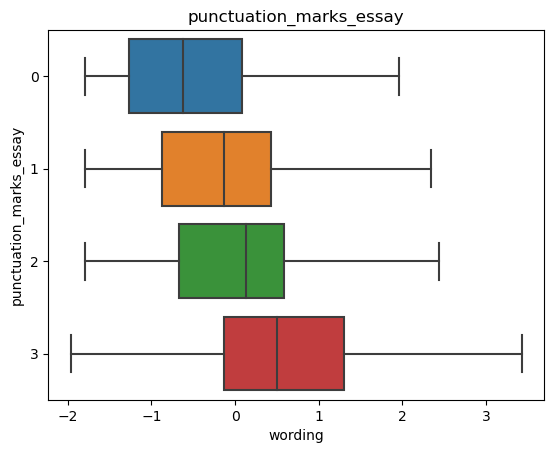

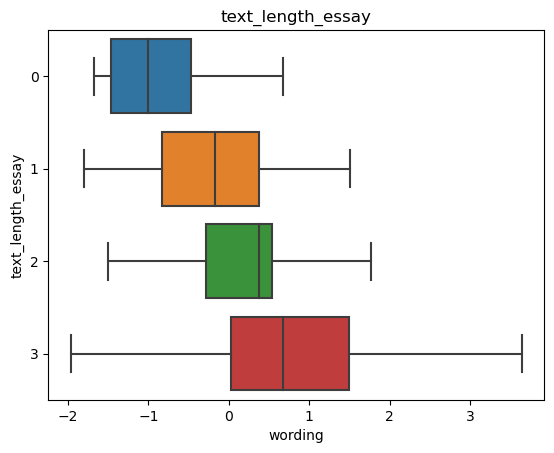

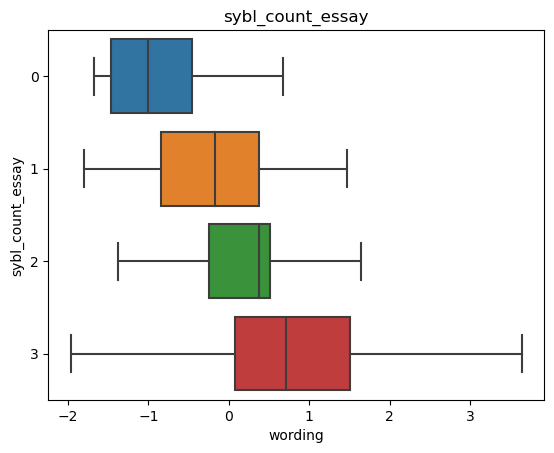

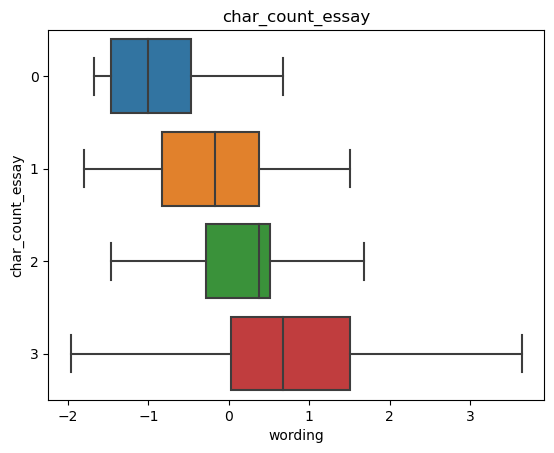

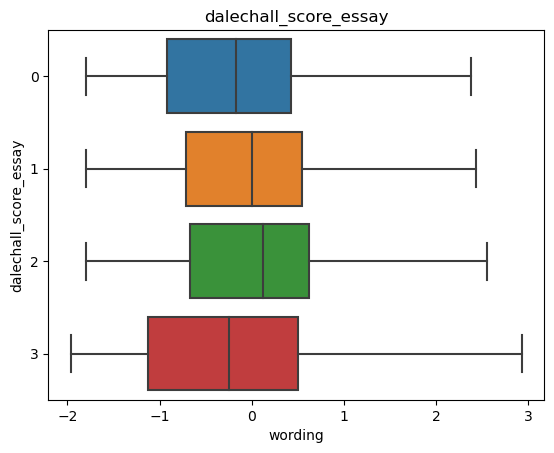

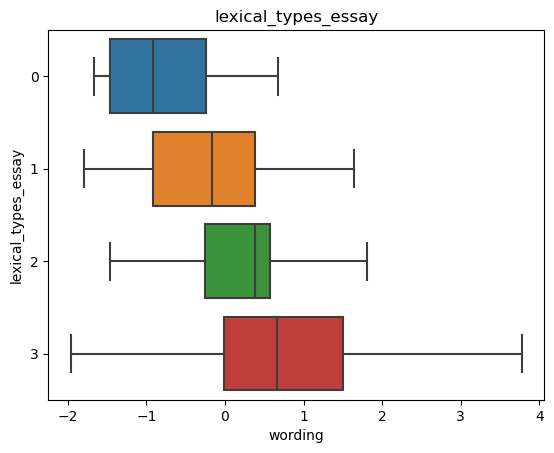

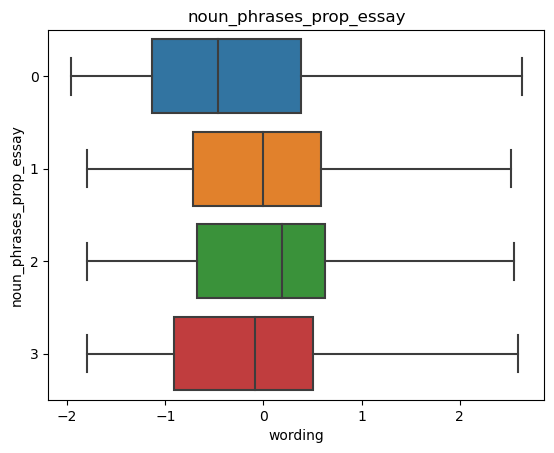

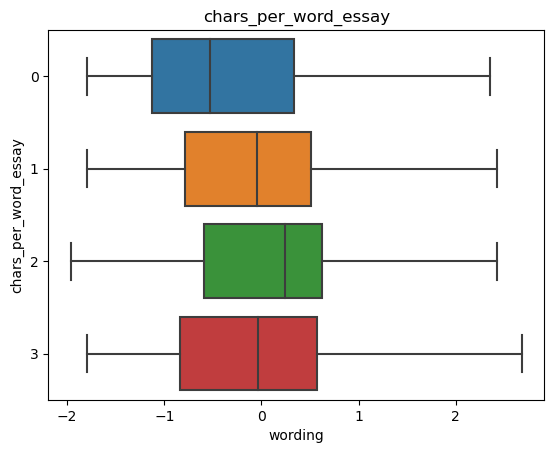

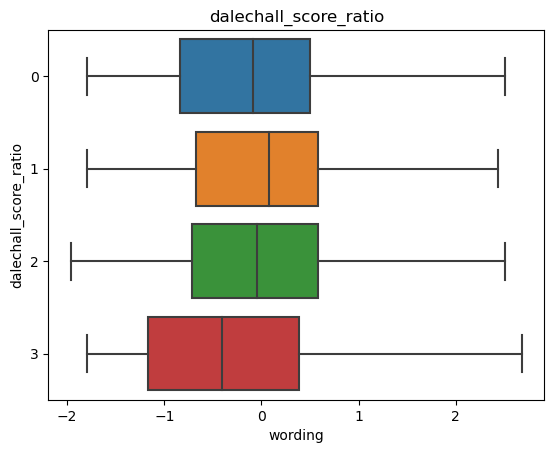

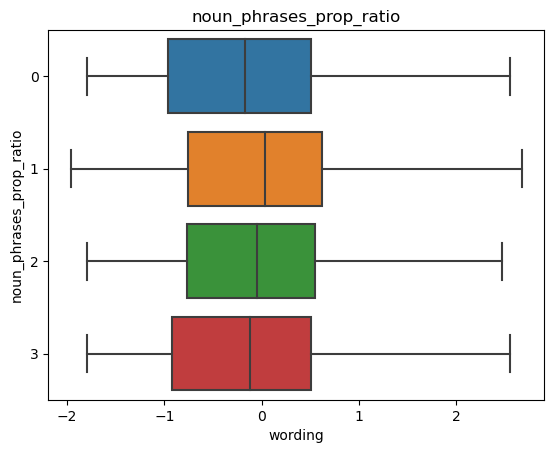

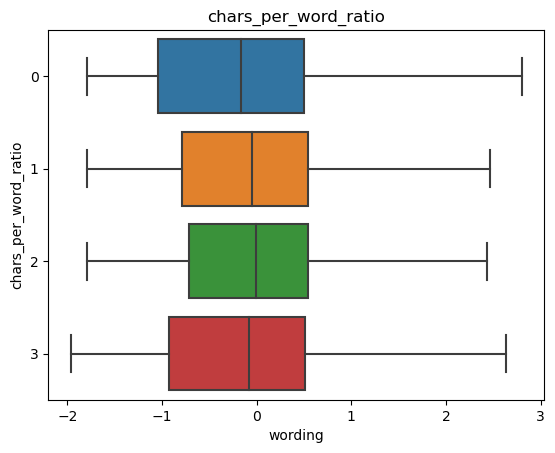

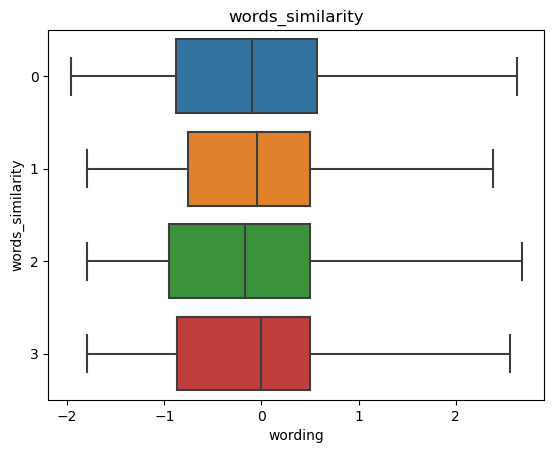

In [23]:
features_to_plot = [feature for feature, importance in wording_importances.items() if importance >= 120]
print(len(features_to_plot))

plot_numeric_features(df, features_to_plot, 'wording')

## Modelo Deep Learning

In [24]:
def r2_score_keras(y_true, y_pred):
    r2 = r2_score(K.eval(y_true), K.eval(y_pred))
    return K.constant(r2, dtype=tf.float32)

In [25]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train['prompt_no_stopwords'] + X_train['question_no_stopwords'] + X_train['essay_no_stopwords'])

max_sequence_length = 100
vocab_size = len(tokenizer.word_index) + 1  

sequences_prompt_texts = tokenizer.texts_to_sequences(X_train['prompt_no_stopwords'])
sequences_prompt_questions = tokenizer.texts_to_sequences(X_train['question_no_stopwords'])
sequences_texts = tokenizer.texts_to_sequences(X_train['essay_no_stopwords'])

prompt_text_train = pad_sequences(sequences_prompt_texts, maxlen=max_sequence_length)
question_text_train = pad_sequences(sequences_prompt_questions, maxlen=max_sequence_length)
essay_text_train = pad_sequences(sequences_texts, maxlen=max_sequence_length)

sequences_prompt_texts = tokenizer.texts_to_sequences(X_val['prompt_no_stopwords'])
sequences_prompt_questions = tokenizer.texts_to_sequences(X_val['question_no_stopwords'])
sequences_texts = tokenizer.texts_to_sequences(X_val['essay_no_stopwords'])

prompt_text_val = pad_sequences(sequences_prompt_texts, maxlen=max_sequence_length)
question_text_val = pad_sequences(sequences_prompt_questions, maxlen=max_sequence_length)
essay_text_val = pad_sequences(sequences_texts, maxlen=max_sequence_length)

### Hyperparameter Tuning

In [26]:
"""
output_dim_values = [50, 100, 150]
lstm_units_values = [32, 64, 128]
lstm_dropout_values = [0.2, 0.5, 0.8]
l2_values = [0.001, 0.01, 0.1]
optimizer_values = ['adam', 'sgd', 'rmsprop']

best_score = float('-inf')
best_params = {}

for output_dim in output_dim_values:
    for units_lstm in lstm_units_values:
        for lstm_dropout in lstm_dropout_values:
            for l2_value in l2_values:
                print(f"Training model with output_dim={output_dim}, units_lstm={units_lstm}, lstm_dropout={lstm_dropout}, l2_value={l2_value}")

                input_prompt_text = Input(shape=(max_sequence_length,))
                input_prompt_question = Input(shape=(max_sequence_length,))
                input_text = Input(shape=(max_sequence_length,))

                embedding_layer = Embedding(input_dim=vocab_size, output_dim=output_dim)
                embedded_prompt_text = embedding_layer(input_prompt_text)
                embedded_prompt_question = embedding_layer(input_prompt_question)
                embedded_text = embedding_layer(input_text)

                lstm_layer = LSTM(units=units_lstm, dropout=lstm_dropout, kernel_regularizer=l2(l2_value))
                lstm_output_prompt_text = lstm_layer(embedded_prompt_text)
                lstm_output_prompt_question = lstm_layer(embedded_prompt_question)
                lstm_output_text = lstm_layer(embedded_text)

                merged_output = concatenate([lstm_output_prompt_text, lstm_output_prompt_question, lstm_output_text])

                dense_layer = Dense(units=2, activation='linear')
                output = dense_layer(merged_output)

                siamese_model = Model(inputs=[input_prompt_text, input_prompt_question, input_text], outputs=output)

                siamese_model.compile(optimizer="adam", loss='mse')

                siamese_model.fit(
                    [prompt_text_train, question_text_train, essay_text_train], Y_train,
                    validation_data=([prompt_text_val, question_text_val, essay_text_val], Y_val),
                    epochs=5, batch_size=128, verbose=1
                )

                score = siamese_model.evaluate([prompt_text_val, question_text_val, essay_text_val], Y_val, verbose=1)

                print(f"Validation Score: {score}")

                if score > best_score:
                    best_score = score
                    best_params = {'output_dim': output_dim, 'units_lstm': units_lstm, 'lstm_dropout': lstm_dropout, 'l2_value': l2_value}

print("Best Parameters:", best_params)
print("Best Score:", best_score)
"""

'\noutput_dim_values = [50, 100, 150]\nlstm_units_values = [32, 64, 128]\nlstm_dropout_values = [0.2, 0.5, 0.8]\nl2_values = [0.001, 0.01, 0.1]\noptimizer_values = [\'adam\', \'sgd\', \'rmsprop\']\n\nbest_score = float(\'-inf\')\nbest_params = {}\n\nfor output_dim in output_dim_values:\n    for units_lstm in lstm_units_values:\n        for lstm_dropout in lstm_dropout_values:\n            for l2_value in l2_values:\n                print(f"Training model with output_dim={output_dim}, units_lstm={units_lstm}, lstm_dropout={lstm_dropout}, l2_value={l2_value}")\n\n                input_prompt_text = Input(shape=(max_sequence_length,))\n                input_prompt_question = Input(shape=(max_sequence_length,))\n                input_text = Input(shape=(max_sequence_length,))\n\n                embedding_layer = Embedding(input_dim=vocab_size, output_dim=output_dim)\n                embedded_prompt_text = embedding_layer(input_prompt_text)\n                embedded_prompt_question = embedd

### Mejor modelo

In [27]:
input_prompt_text = Input(shape=(max_sequence_length,))
input_prompt_question = Input(shape=(max_sequence_length,))
input_text = Input(shape=(max_sequence_length,))

embedding_layer = Embedding(input_dim=vocab_size, output_dim=50)
embedded_prompt_text = embedding_layer(input_prompt_text)
embedded_prompt_question = embedding_layer(input_prompt_question)
embedded_text = embedding_layer(input_text)

lstm_layer = LSTM(units=64, dropout=0.5, kernel_regularizer=l2(0.001))
lstm_output_prompt_text = lstm_layer(embedded_prompt_text)
lstm_output_prompt_question = lstm_layer(embedded_prompt_question)
lstm_output_text = lstm_layer(embedded_text)

merged_output = concatenate([lstm_output_prompt_text, lstm_output_prompt_question, lstm_output_text])

dense_layer = Dense(units=2, activation='linear')
output = dense_layer(merged_output)

final_model = Model(inputs=[input_prompt_text, input_prompt_question, input_text], outputs=output)
final_model.compile(optimizer="adam", loss='mse')

In [28]:
history = final_model.fit(
    [prompt_text_train, question_text_train, essay_text_train], Y_train,
    validation_data=([prompt_text_val, question_text_val, essay_text_val], Y_val),
    epochs=8, batch_size=150, verbose=1
)

Epoch 1/8
39/39 [==============================] - 40s 856ms/step - loss: 0.9264 - val_loss: 0.5331
Epoch 2/8
39/39 [==============================] - 36s 921ms/step - loss: 0.4689 - val_loss: 0.4028
Epoch 3/8
39/39 [==============================] - 38s 977ms/step - loss: 0.3903 - val_loss: 0.3599
Epoch 4/8
39/39 [==============================] - 37s 940ms/step - loss: 0.3426 - val_loss: 0.3642
Epoch 5/8
39/39 [==============================] - 36s 921ms/step - loss: 0.3153 - val_loss: 0.3362
Epoch 6/8
39/39 [==============================] - 38s 989ms/step - loss: 0.2879 - val_loss: 0.3409
Epoch 7/8
39/39 [==============================] - 38s 962ms/step - loss: 0.2689 - val_loss: 0.3345
Epoch 8/8
39/39 [==============================] - 37s 950ms/step - loss: 0.2431 - val_loss: 0.3308


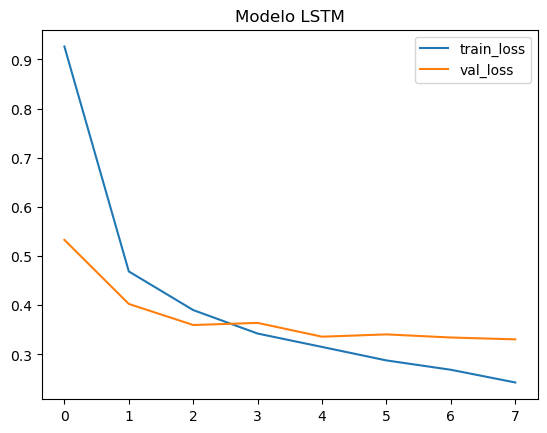

In [29]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title("Modelo LSTM")
plt.show()

In [30]:
nn_predictions_train = final_model.predict([prompt_text_train, question_text_train, essay_text_train])
nn_predictions_val = final_model.predict([prompt_text_val, question_text_val, essay_text_val])

regression_report(Y_train['content'], nn_predictions_train[:, 0], 'CONTENT TRAIN')
regression_report(Y_val['content'], nn_predictions_val[:, 0], 'CONTENT TEST')

regression_report(Y_train['content'], nn_predictions_train[:, 1], 'WORDING TRAIN')
regression_report(Y_val['content'], nn_predictions_val[:, 1], 'WORDING TEST')

45/45 [==============================] - 1s 25ms/step
CONTENT TRAIN
std = 1.0487952988077796
rmse = 0.398121756026266
r2 = 0.8559045200111777 

CONTENT TEST
std = 1.0220265405010216
rmse = 0.48749729820431587
r2 = 0.7724797384175371 

WORDING TRAIN
std = 1.0487952988077796
rmse = 0.6115465825948356
r2 = 0.6600010128525545 

WORDING TEST
std = 1.0220265405010216
rmse = 0.6921372788784544
r2 = 0.5413724551993507 



## Stacking

In [31]:
X_train_features["NN_prediction1"] = nn_predictions_train[:, 0]
X_train_features["NN_prediction2"] = nn_predictions_train[:, 1]

X_val_features["NN_prediction1"] = nn_predictions_val[:, 0]
X_val_features["NN_prediction2"] = nn_predictions_val[:, 1]

In [32]:
"""
xgb_model_stack = XGBRegressor(objective='reg:squarederror', seed=2023)

param_dist = {
    'learning_rate': uniform(0.01, 0.2),
    'max_depth': randint(5, 30),
    'n_estimators': randint(50, 200),
    'min_child_weight': randint(50, 150),
    'subsample': uniform(0.8, 0.2),
    'colsample_bytree': uniform(0.8, 0.2),
    'gamma': uniform(0, 0.2),
    'reg_alpha': uniform(0, 0.2),
    'reg_lambda': uniform(0, 0.2),
    'scale_pos_weight': randint(1, 4),
    'max_delta_step': randint(0, 3)
}

random_search_stack = RandomizedSearchCV(xgb_model_stack, param_distributions=param_dist, n_iter=50, cv=3, scoring='neg_mean_squared_error', random_state=2023, n_jobs=-1)

random_search_stack.fit(X_train_features, Y_train)

print("Best Hyperparameters:", random_search_stack.best_params_)

best_model = random_search_stack.best_estimator_
multi_xgb_model_stack = MultiOutputRegressor(best_model)
best_model.fit(X_train_features, Y_train)
"""

'\nxgb_model_stack = XGBRegressor(objective=\'reg:squarederror\', seed=2023)\n\nparam_dist = {\n    \'learning_rate\': uniform(0.01, 0.2),\n    \'max_depth\': randint(5, 30),\n    \'n_estimators\': randint(50, 200),\n    \'min_child_weight\': randint(50, 150),\n    \'subsample\': uniform(0.8, 0.2),\n    \'colsample_bytree\': uniform(0.8, 0.2),\n    \'gamma\': uniform(0, 0.2),\n    \'reg_alpha\': uniform(0, 0.2),\n    \'reg_lambda\': uniform(0, 0.2),\n    \'scale_pos_weight\': randint(1, 4),\n    \'max_delta_step\': randint(0, 3)\n}\n\nrandom_search_stack = RandomizedSearchCV(xgb_model_stack, param_distributions=param_dist, n_iter=50, cv=3, scoring=\'neg_mean_squared_error\', random_state=2023, n_jobs=-1)\n\nrandom_search_stack.fit(X_train_features, Y_train)\n\nprint("Best Hyperparameters:", random_search_stack.best_params_)\n\nbest_model = random_search_stack.best_estimator_\nmulti_xgb_model_stack = MultiOutputRegressor(best_model)\nbest_model.fit(X_train_features, Y_train)\n'

In [33]:
xgb_model_stack = xgb.XGBRegressor(
    objective='reg:squarederror',
    seed=24,
    colsample_bytree=0.918,
    gamma=0.135,
    learning_rate=0.028,
    min_child_weight=58,
    max_depth=28,
    reg_alpha=0.0837,
    reg_lambda=0.0437,
    subsample=0.822,
    n_estimators=145
)

multi_xgb_model_stack = MultiOutputRegressor(xgb_model_stack).fit(X_train_features, Y_train)

multi_xgb_model_stack.fit(X_train_features, Y_train)
predictions_stack = multi_xgb_model_stack.predict(X_val_features)

In [34]:
regression_report(Y_train['content'], multi_xgb_model_stack.predict(X_train_features)[:, 0], 'CONTENT TRAIN')
regression_report(Y_val['content'], predictions_stack[:, 0], 'CONTENT TEST')

regression_report(Y_train['wording'], multi_xgb_model_stack.predict(X_train_features)[:, 1], 'WORDING TRAIN')
regression_report(Y_val['wording'], predictions_stack[:, 1], 'WORDING TEST')

CONTENT TRAIN
std = 1.0487952988077796
rmse = 0.2919537904687415
r2 = 0.9225098016969198 

CONTENT TEST
std = 1.0220265405010216
rmse = 0.4419648039851302
r2 = 0.8129959452827408 

WORDING TRAIN
std = 1.04289755999341
rmse = 0.3671195040678513
r2 = 0.8760827938286427 

WORDING TEST
std = 1.0075341042027464
rmse = 0.5812392475169424
r2 = 0.6671946090761125 



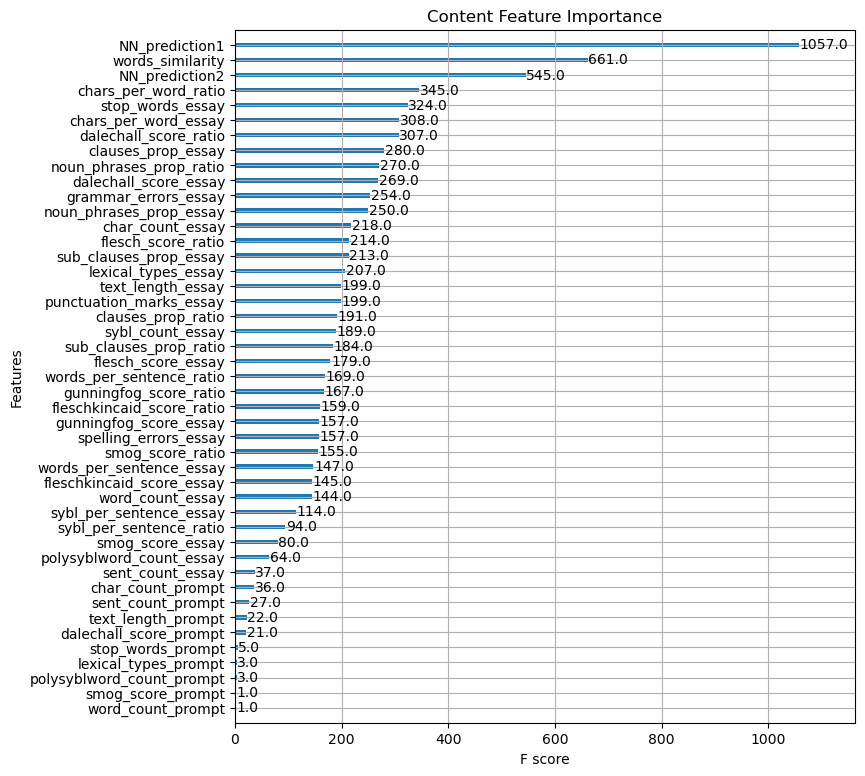

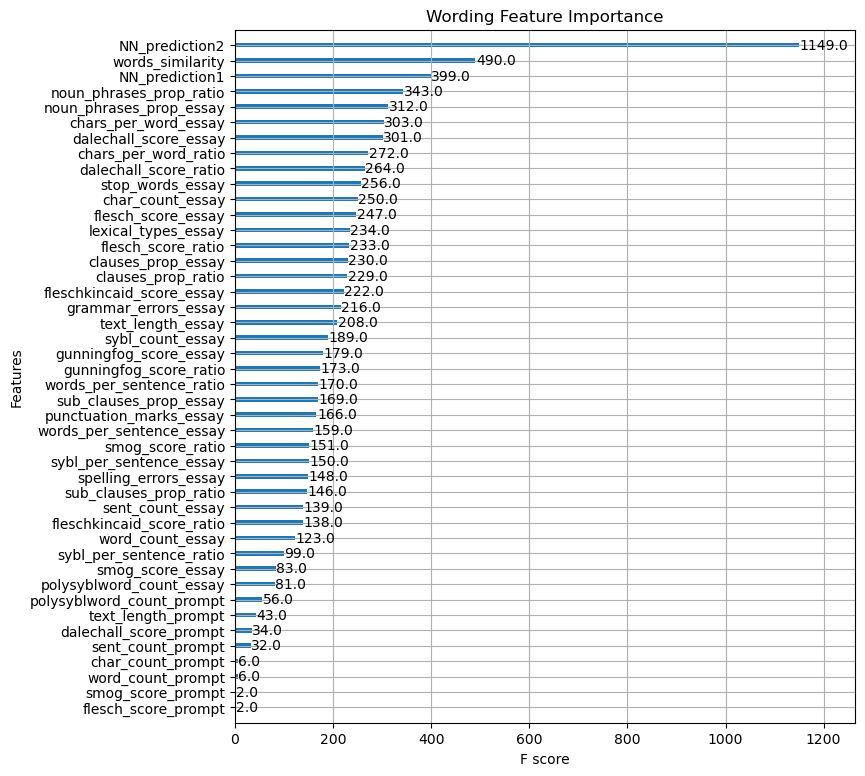

In [49]:
fig, ax = plt.subplots(figsize=(8, 9))
xgb.plot_importance(multi_xgb_model_stack.estimators_[0], height=0.3, title='Content Feature Importance', ax=ax)
plt.show()

fig, ax = plt.subplots(figsize=(8, 9))
xgb.plot_importance(multi_xgb_model_stack.estimators_[1], height=0.3, title='Wording Feature Importance', ax=ax)
plt.show()

## Análisis de Resultados

In [36]:
def plot_predictions(df, target_col, pred_col):
    sns.jointplot(
        x=target_col, 
        y=pred_col,
        data=df_val,
        kind='reg',
        joint_kws=dict(line_kws=dict(color='r', linewidth=3), scatter_kws=dict(alpha=0.5, s=10)),
    )
    plt.show()

def plot_predictions_features(df, features, target_col, pred_col, bins=5):
    df_plot = df.copy()
    
    r2_general = mean_squared_error(df_plot[target_col], df_plot[pred_col])
    
    for col in features:
        df_plot[col] = pd.qcut(df[col], q=bins, labels=False)
        
        sns.jointplot(
            x=target_col, 
            y=pred_col,
            data=df_plot,
            kind='scatter',
            hue=col
            #joint_kws=dict(line_kws=dict(color='r', linewidth=3), scatter_kws=dict(alpha=0.5, s=10)),
        )
        
        plt.show()
        
        r2_bins = [mean_squared_error(
            df_plot[df_plot[col] == i][target_col], 
            df_plot[df_plot[col] == i][pred_col]
        ) for i in range(bins)]
        
        plt.axhline(y=r2_general, color='r', linestyle='--')
        plt.plot(r2_bins)
        plt.title(col + ' R2 scores')
        plt.show()
        
def plot_predictions_comparisson(df, features, target_col, pred_col_1, pred_col_2, bins=5):
    df_plot = df.copy()
    
    r2_general_1 = mean_squared_error(df_plot[target_col], df_plot[pred_col_1])
    r2_general_2 = mean_squared_error(df_plot[target_col], df_plot[pred_col_2])
    
    for col in features:
        df_plot[col] = pd.qcut(df[col], q=bins, labels=False)
        
        r2_bins_1 = [mean_squared_error(
            df_plot[df_plot[col] == i][target_col], 
            df_plot[df_plot[col] == i][pred_col_1]
        ) for i in range(bins)]
        
        r2_bins_2 = [mean_squared_error(
            df_plot[df_plot[col] == i][target_col], 
            df_plot[df_plot[col] == i][pred_col_2]
        ) for i in range(bins)]
        
        plt.axhline(y=r2_general_1, color='#1f77b4', linestyle='--')
        plt.axhline(y=r2_general_2, color='#ff7f0e', linestyle='--')
        plt.plot(r2_bins_1, label=pred_col_1, color='#1f77b4')
        plt.plot(r2_bins_2, label=pred_col_2, color='#ff7f0e')
        plt.legend()
        plt.title(col + ' MSE scores')
        plt.show()

In [37]:
df_val = X_val_features.join(Y_val)
df_val[['content_pred', 'wording_pred']] = predictions_stack
df_val.head()

spelling_errors_essay  grammar_errors_essay  punctuation_marks_essay  \
1759                      5                     2                        8   
2313                      3                     7                        1   
2282                      3                     7                        1   
2740                      8                     2                        7   
3978                      3                     0                        3   

      text_length_essay  sent_count_essay  word_count_essay  sybl_count_essay  \
1759                347               3.0              70.0              77.0   
2313                226               1.0              49.0              55.0   
2282                331               1.0              63.0              78.0   
2740                286               2.0              58.0              62.0   
3978                180               1.0              29.0              47.0   

      char_count_essay  polysyblword_count_essay  dalechall_score_essay  ...  \
1759             272.0                       0.0               6.147262  ...   
2313             177.0                       1.0               7.355880  ...   
2282             268.0                       5.0               9.768919  ...   
2740             226.0                       0.0               1.982883  ...   
3978             150.0                       5.0               9.430762  ...   

      chars_per_word_ratio  words_per_sentence_ratio  sybl_per_sentence_ratio  \
1759              0.922239                  0.589821                 0.555075   
2313              0.857334                  1.238625                 1.189446   
2282              0.927127                  2.625000                 2.522639   
2740              0.924812                  0.733064                 0.670415   
3978              1.227626                  0.733064                 1.016436   

      words_similarity  NN_prediction1  NN_prediction2   content   wording  \
1759          0.095279       -0.380036       -0.437805 -0.301962  0.077857   
2313          0.096369       -0.713149       -0.710093 -0.511077 -1.589115   
2282          0.098061        0.028432        0.374196 -0.826271 -1.428527   
2740          0.091173       -0.597101       -1.049852 -1.033882 -1.086703   
3978          0.108956       -1.225944       -1.066320 -1.547163 -1.461245   

      content_pred  wording_pred  
1759     -0.129899     -0.274383  
2313     -0.840288     -0.799270  
2282     -0.165638     -0.033783  
2740     -0.616726     -0.916846  
3978     -1.343213     -1.232113  

[5 rows x 82 columns]

### Resultados Deep Learning

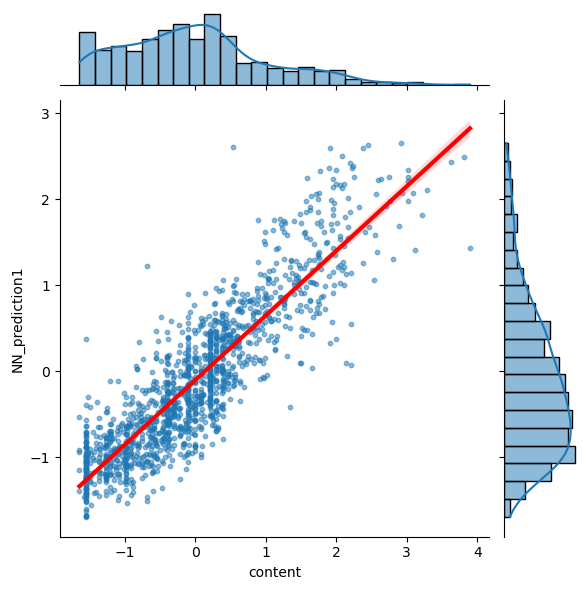

In [38]:
plot_predictions(df_val, 'content', 'NN_prediction1')

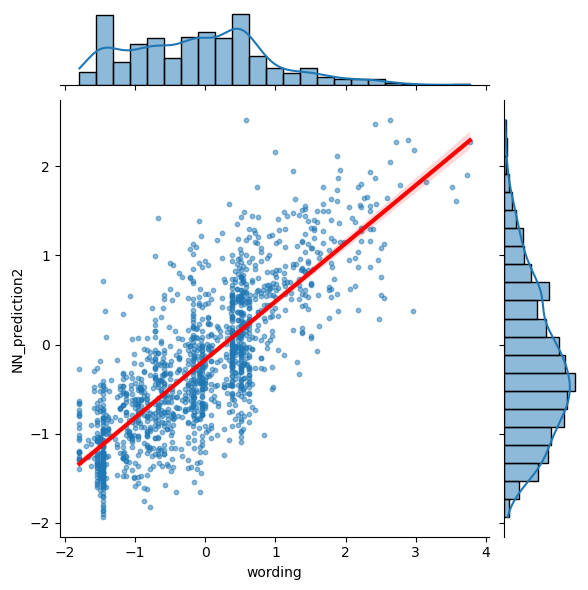

In [39]:
plot_predictions(df_val, 'wording', 'NN_prediction2')

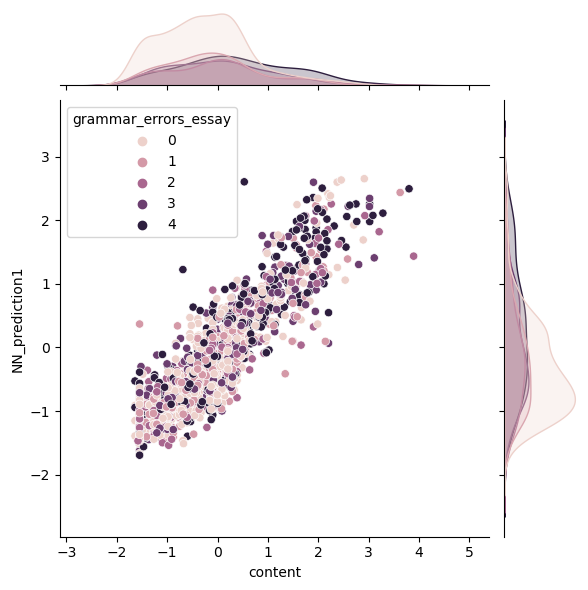

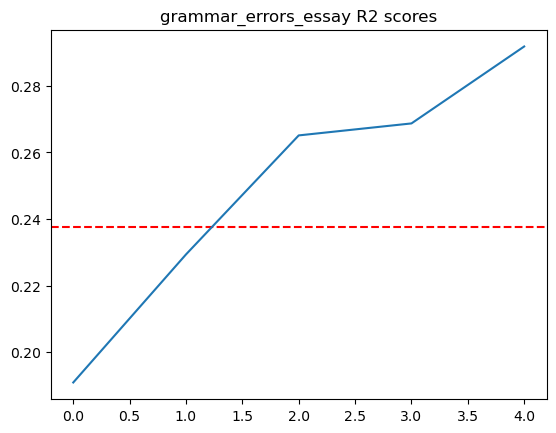

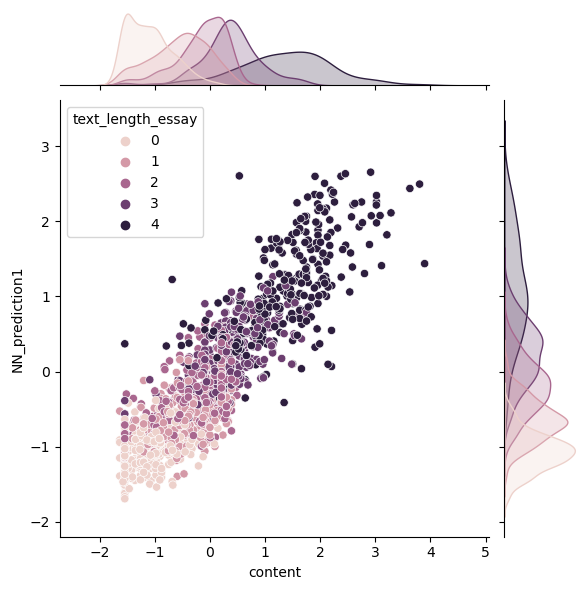

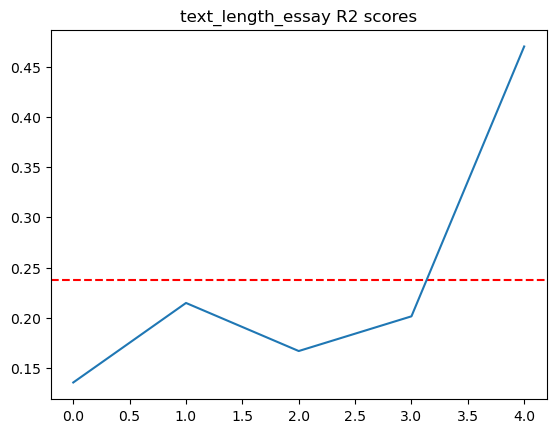

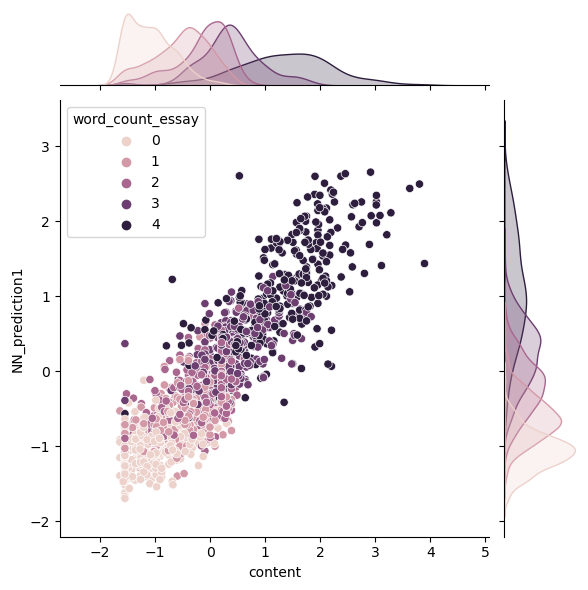

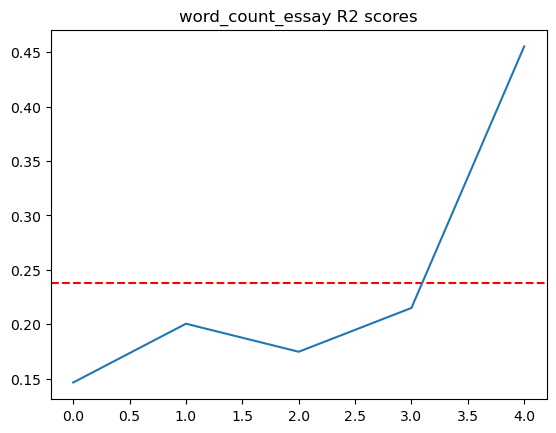

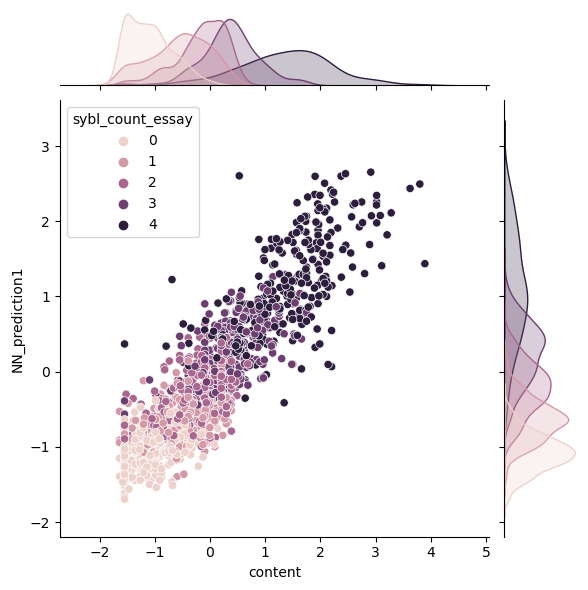

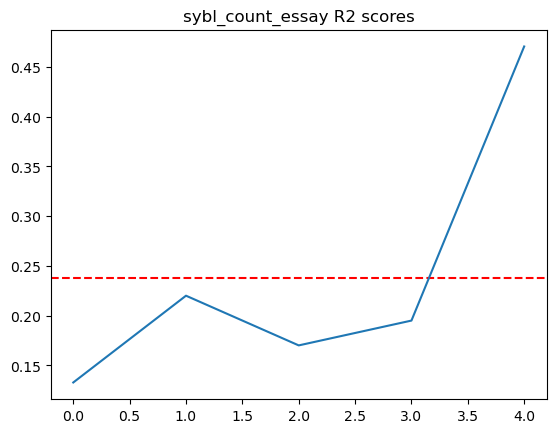

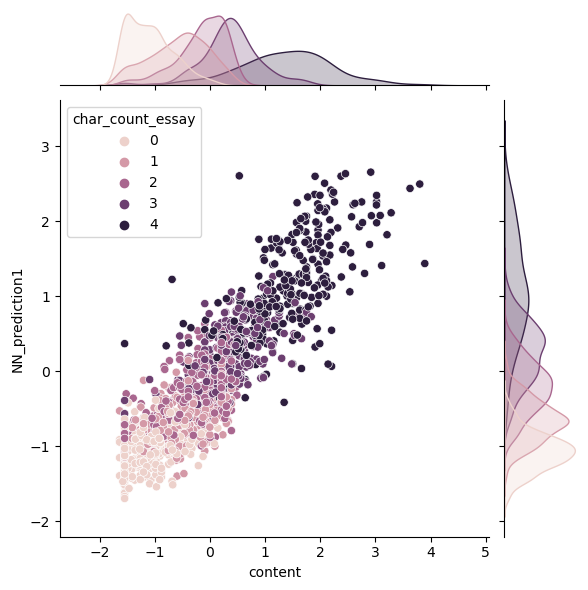

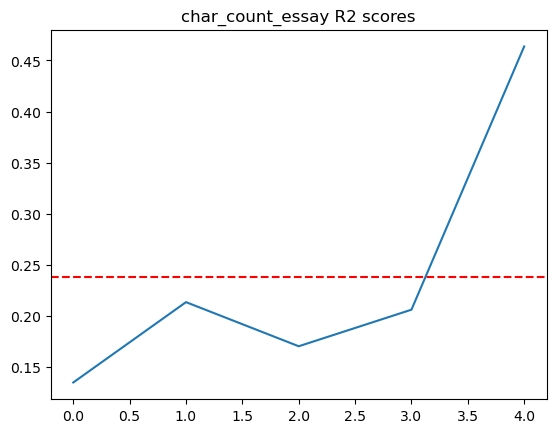

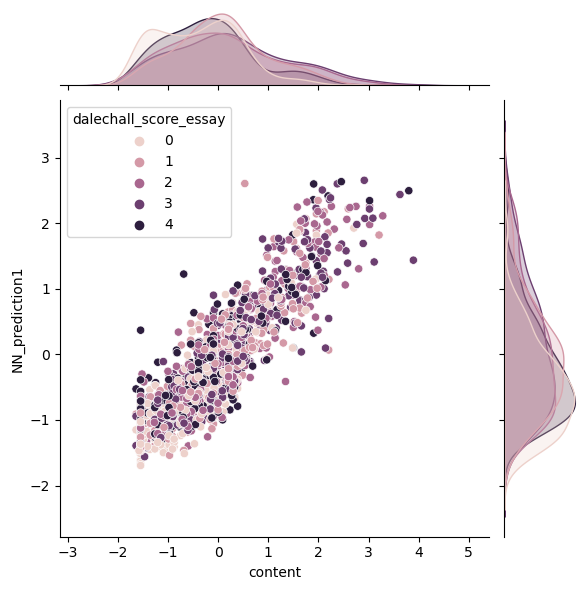

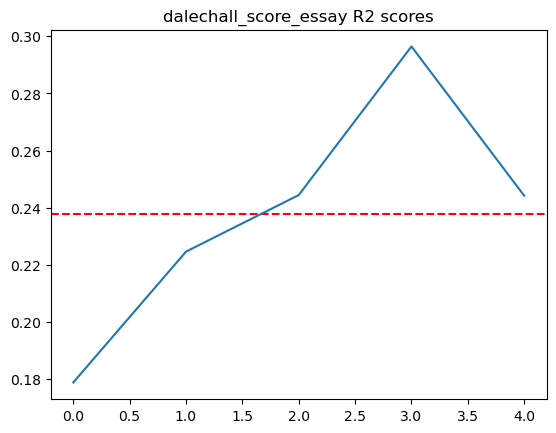

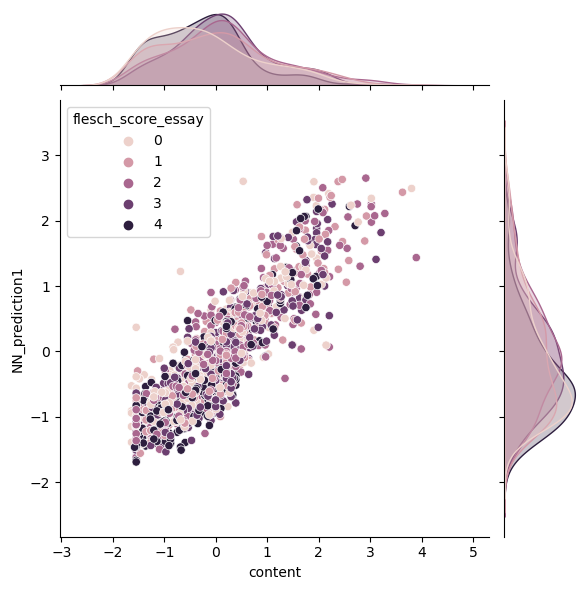

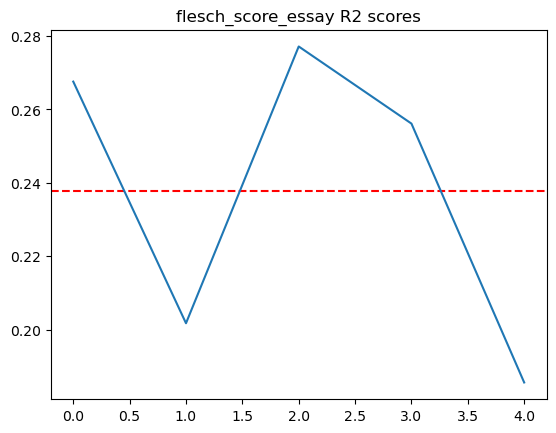

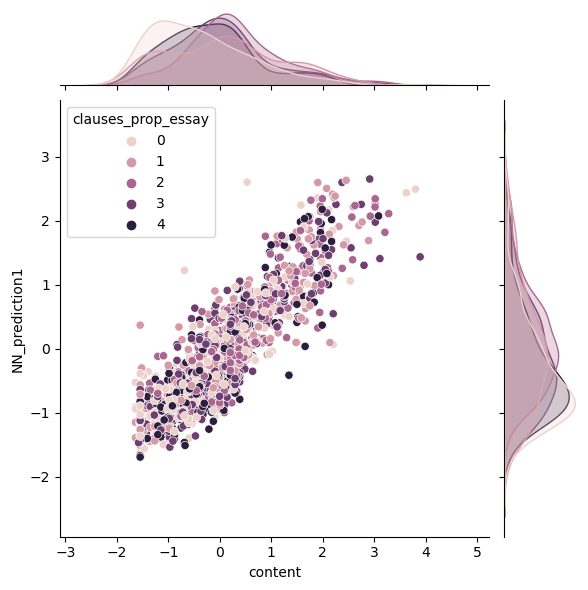

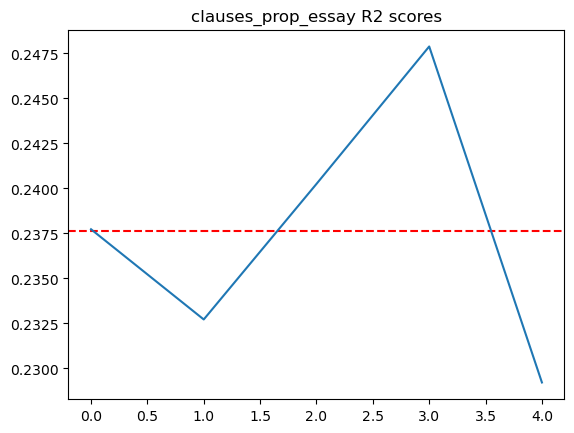

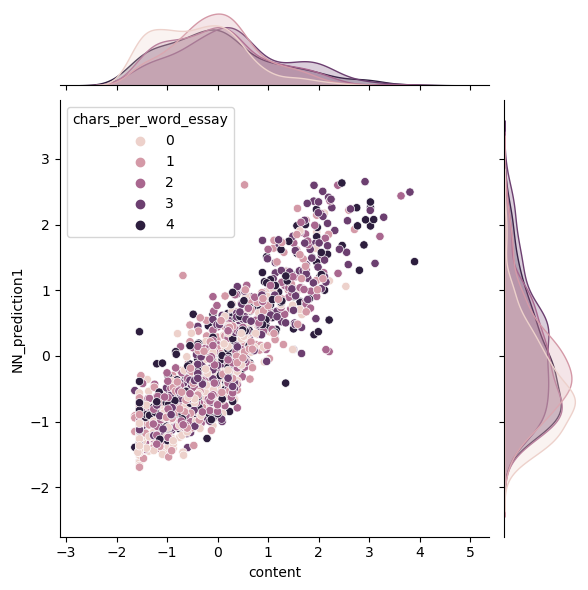

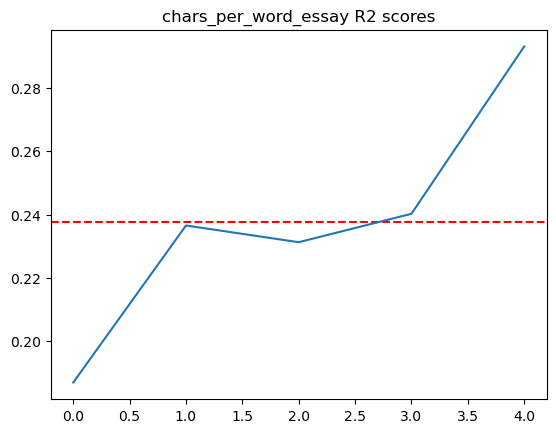

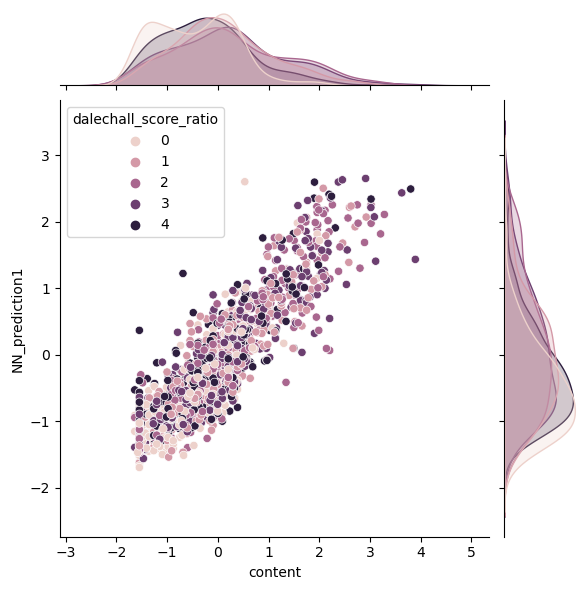

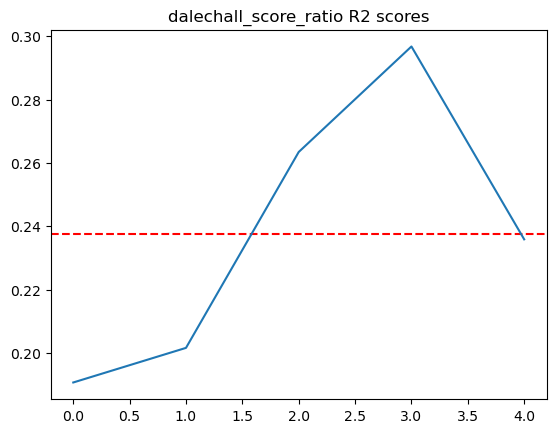

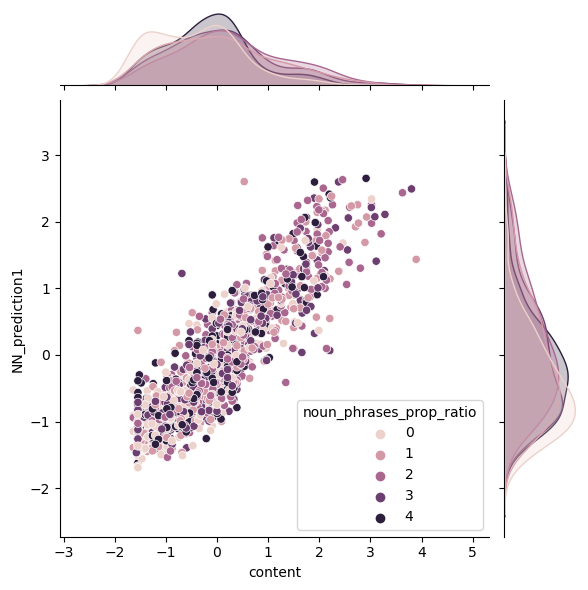

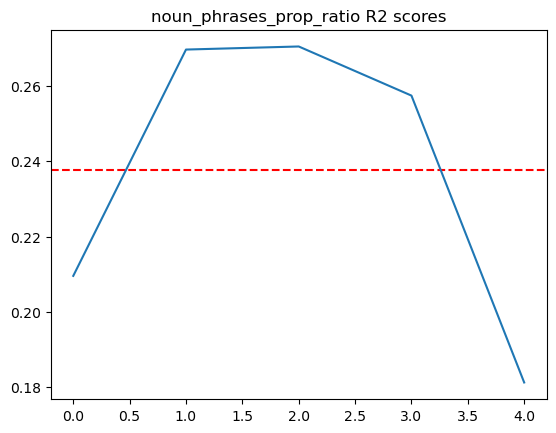

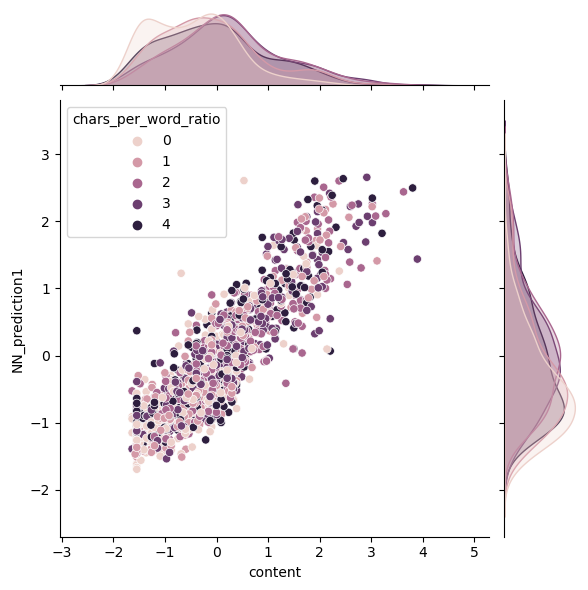

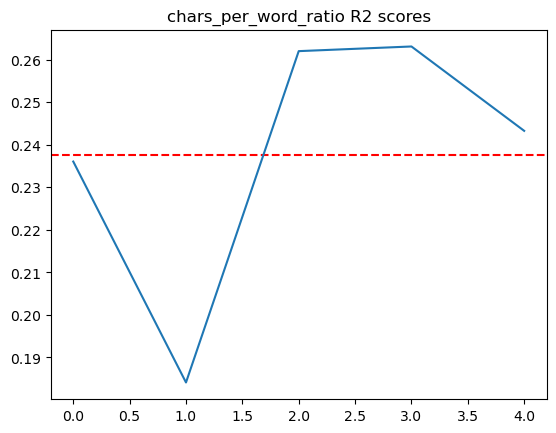

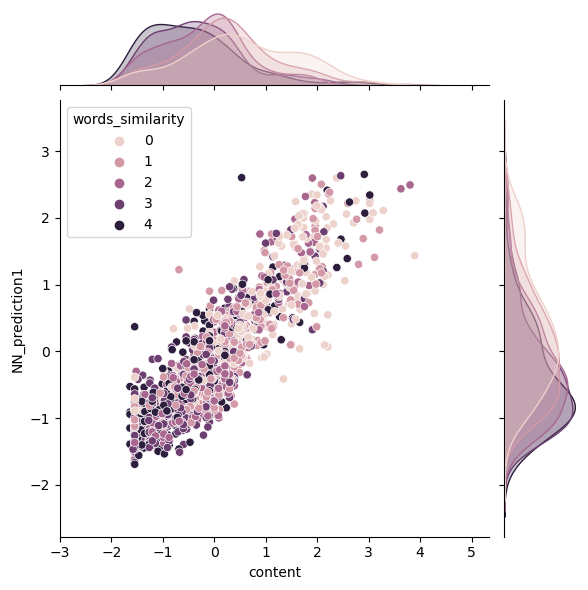

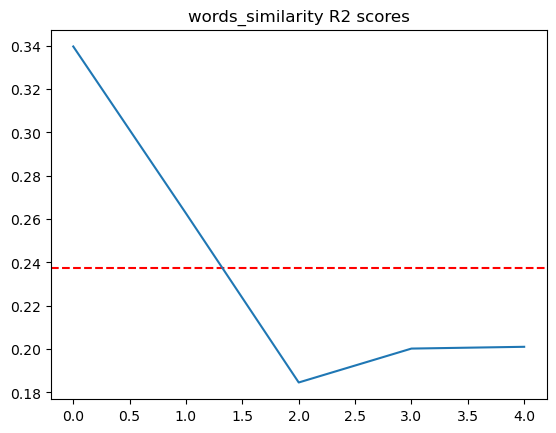

In [40]:
content_features = [feature for feature, importance in content_importances.items() if importance >= 130]
plot_predictions_features(df_val, content_features, 'content', 'NN_prediction1')

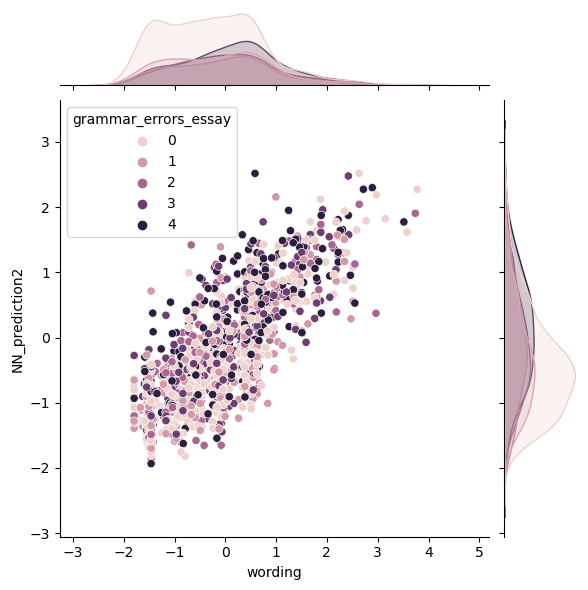

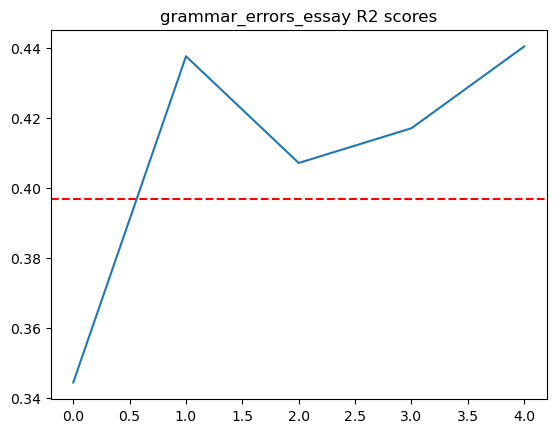

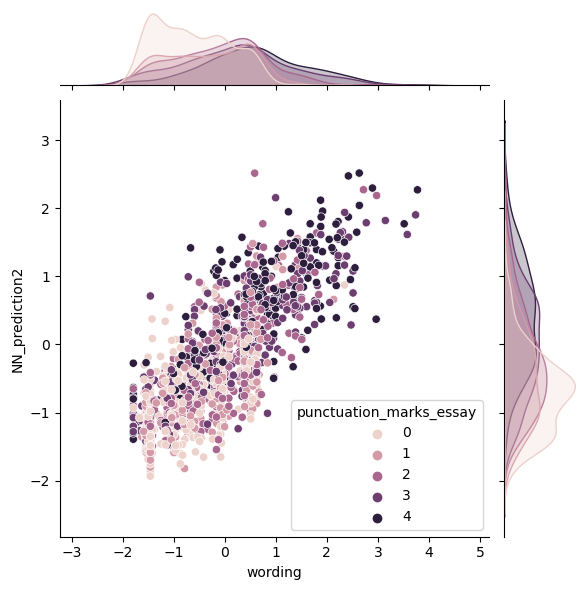

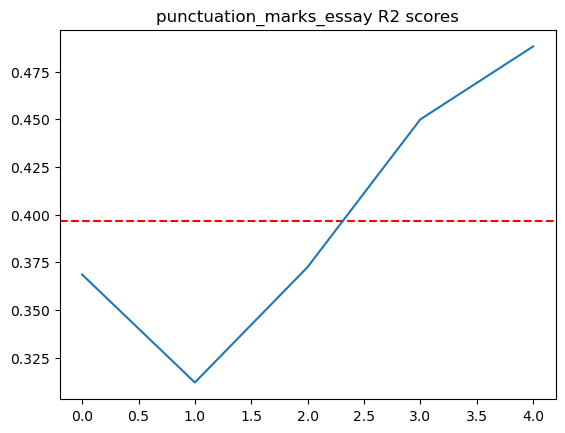

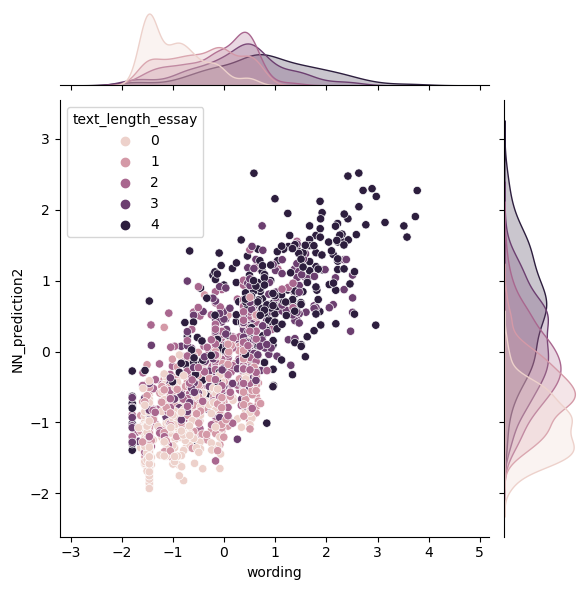

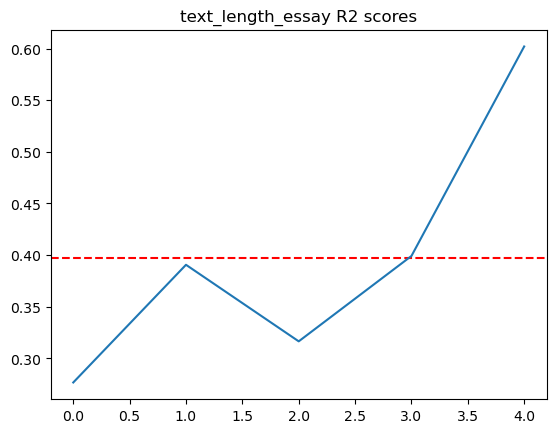

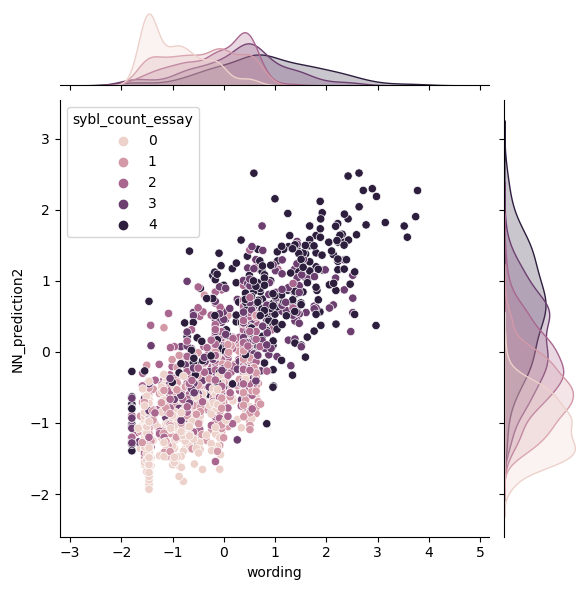

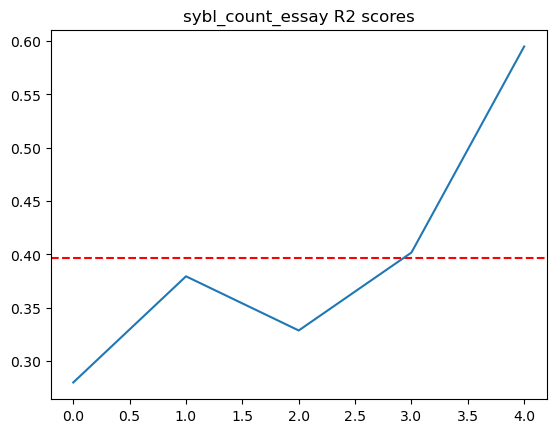

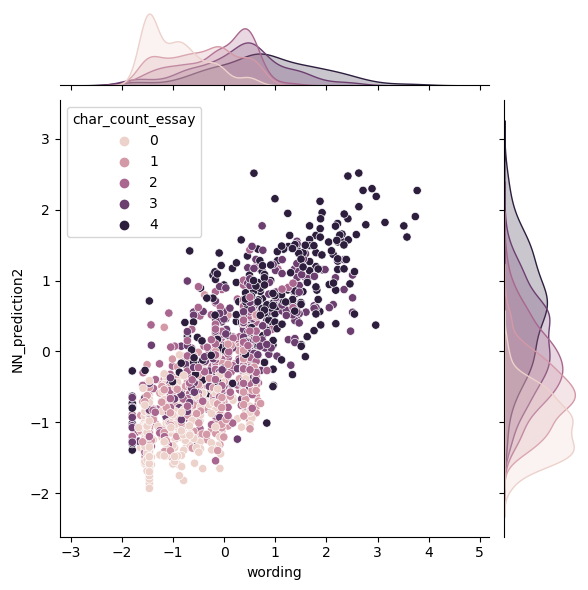

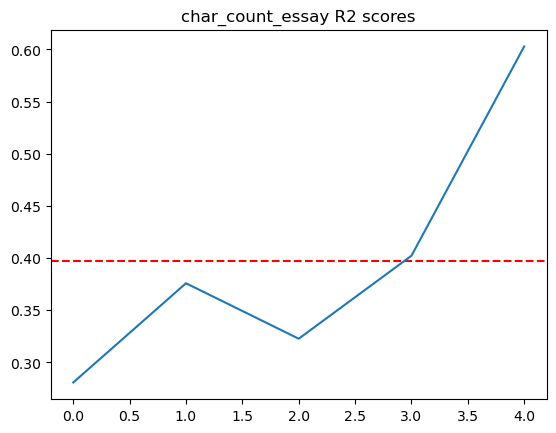

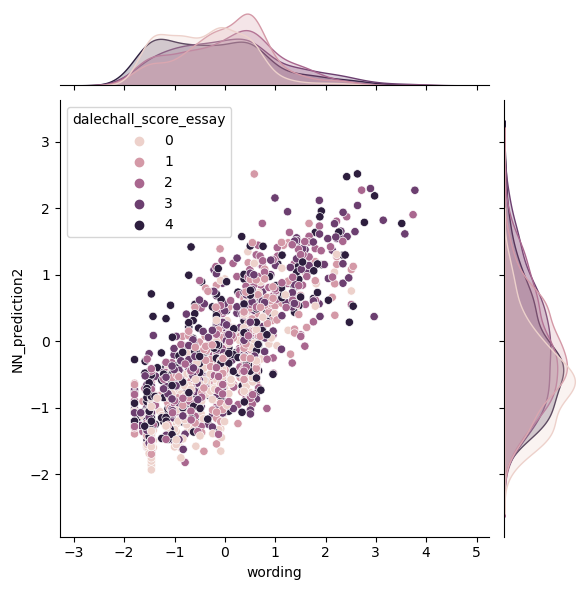

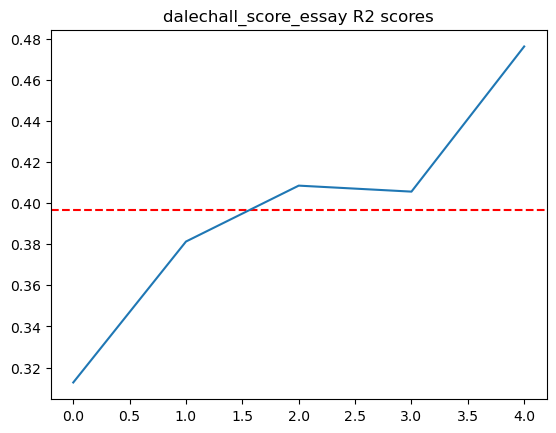

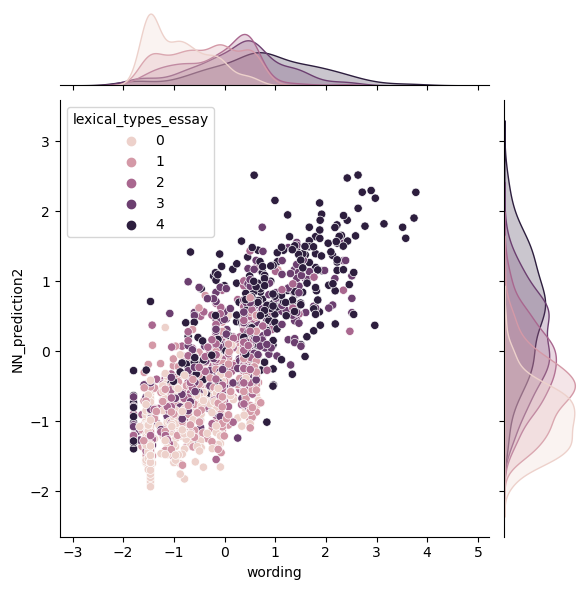

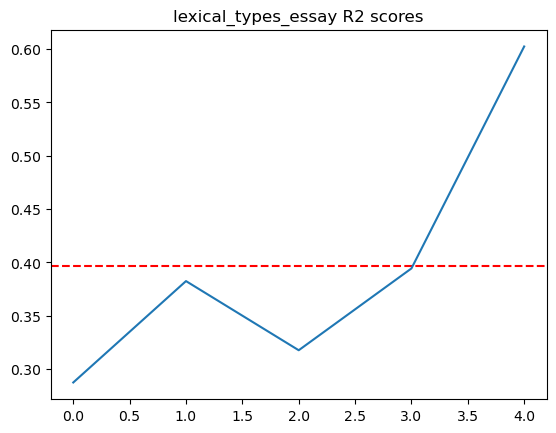

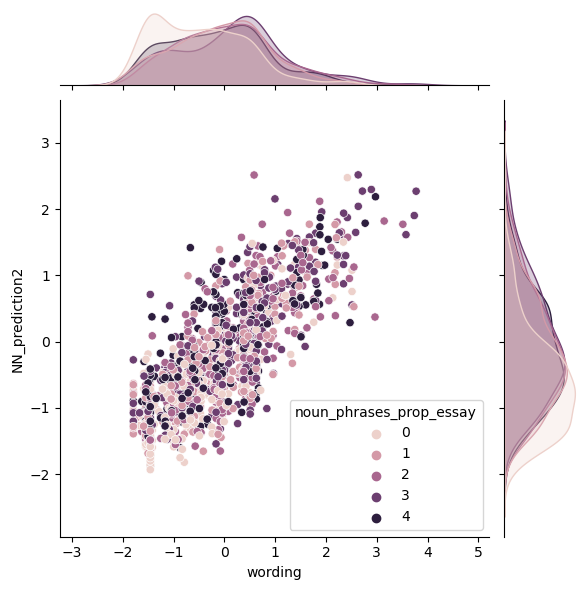

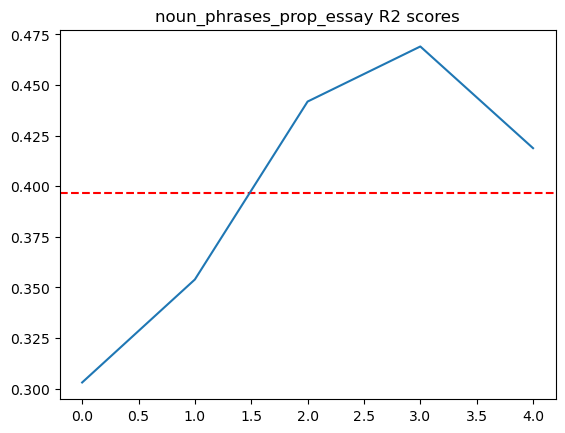

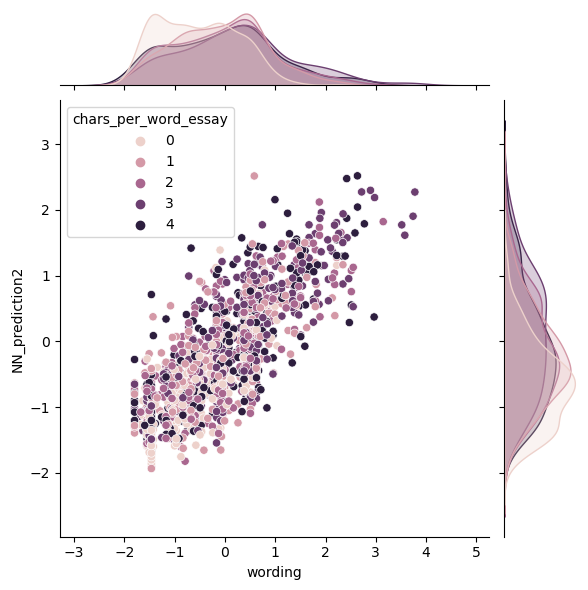

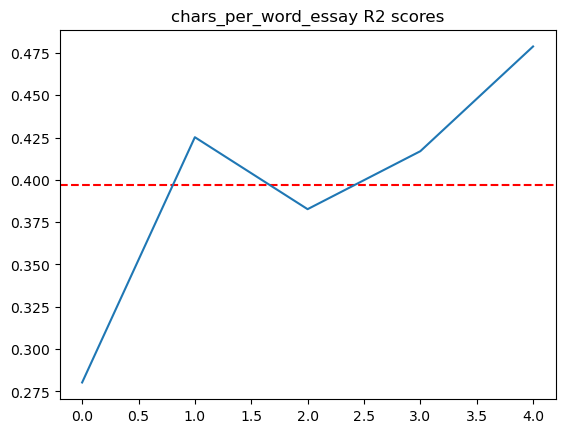

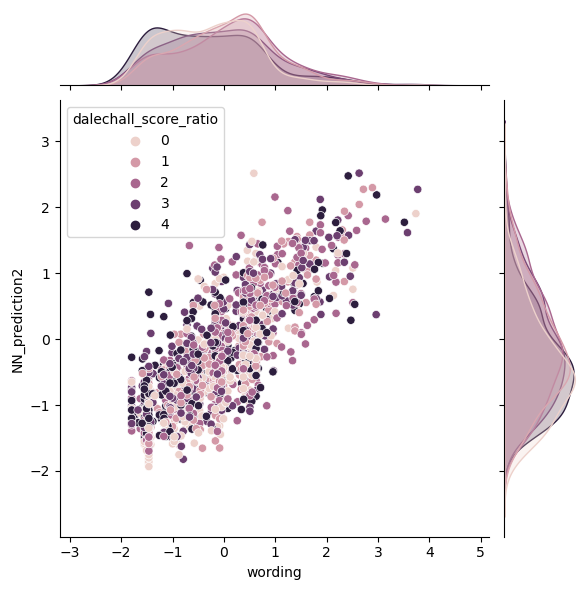

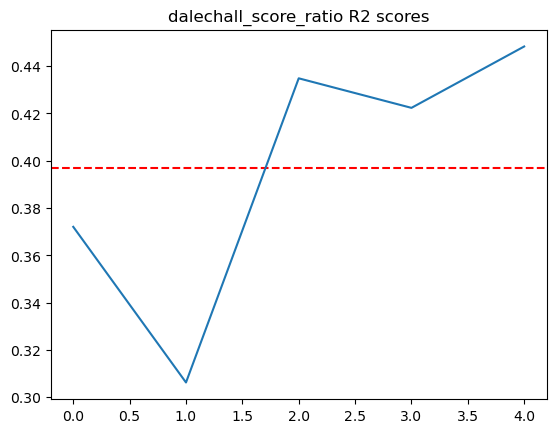

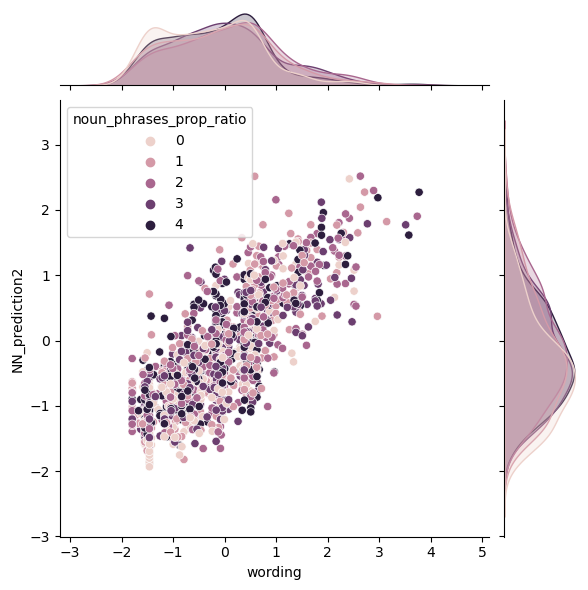

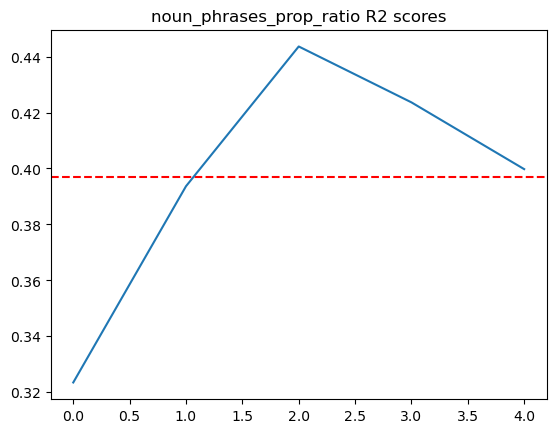

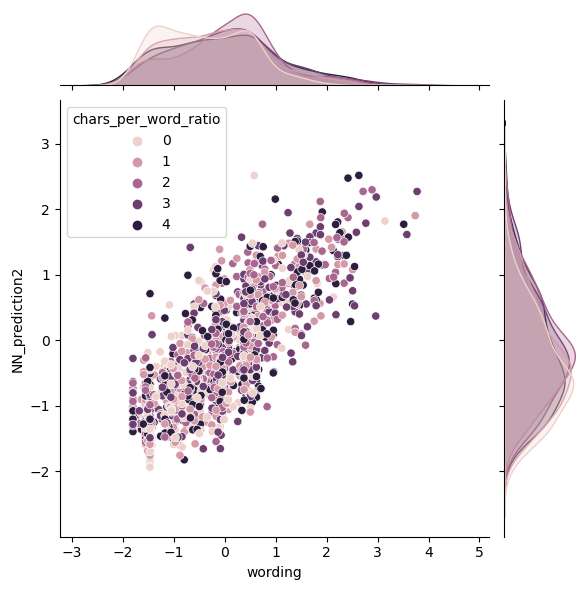

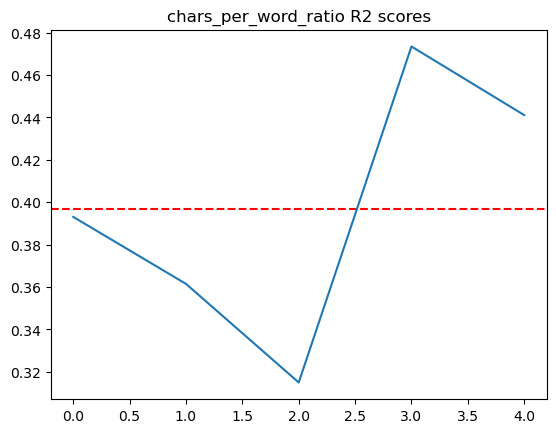

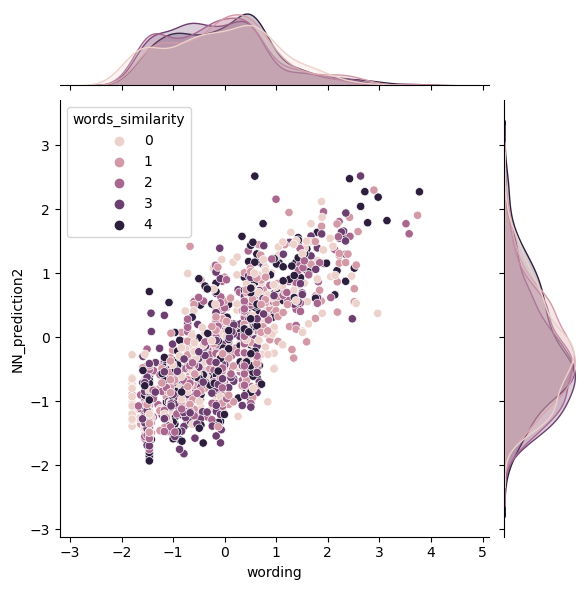

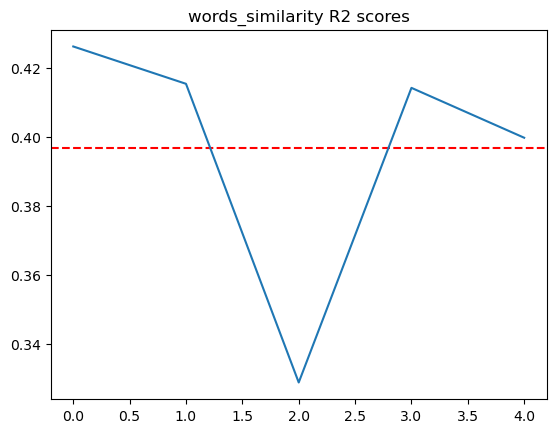

In [41]:
wording_features = [feature for feature, importance in wording_importances.items() if importance >= 120]
plot_predictions_features(df_val, wording_features, 'wording', 'NN_prediction2')

### Resutados Deep Learning vs Stacking

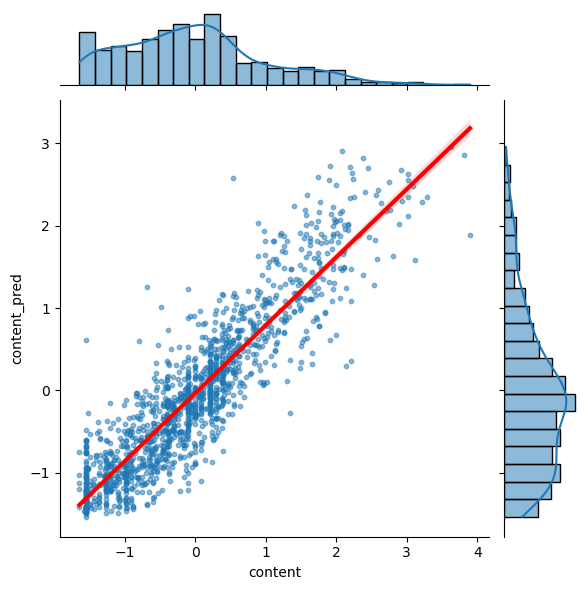

In [42]:
plot_predictions(df_val, 'content', 'content_pred')

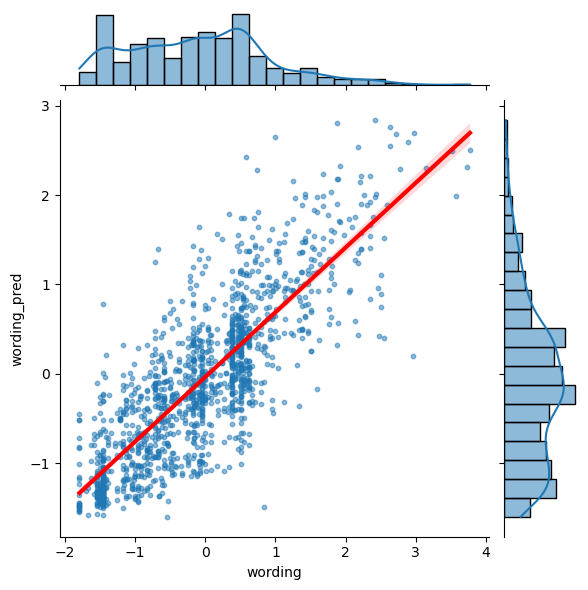

In [56]:
plot_predictions(df_val, 'wording', 'wording_pred')

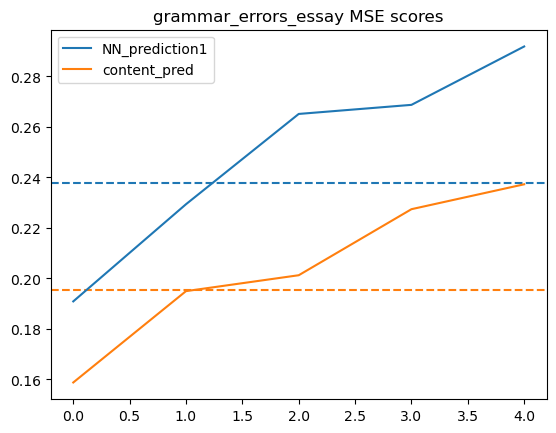

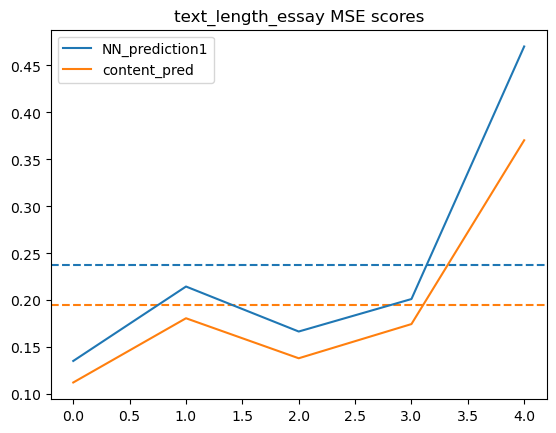

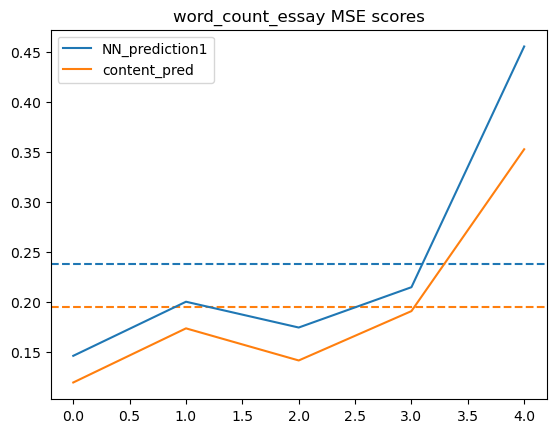

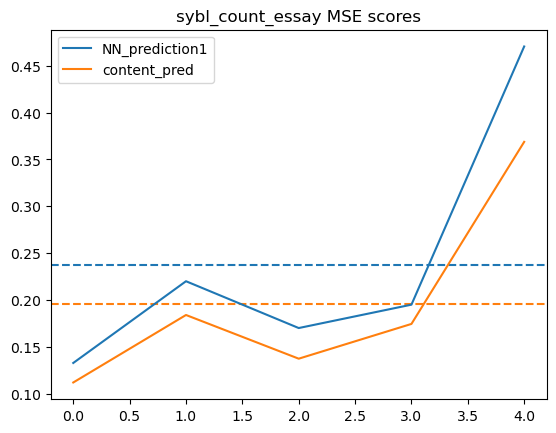

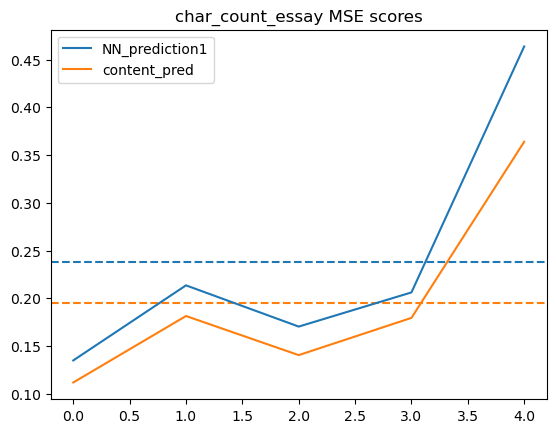

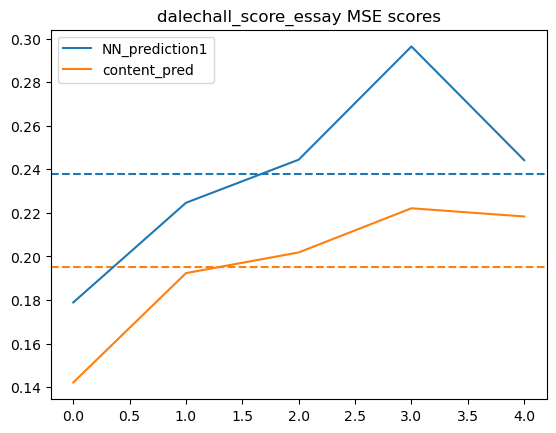

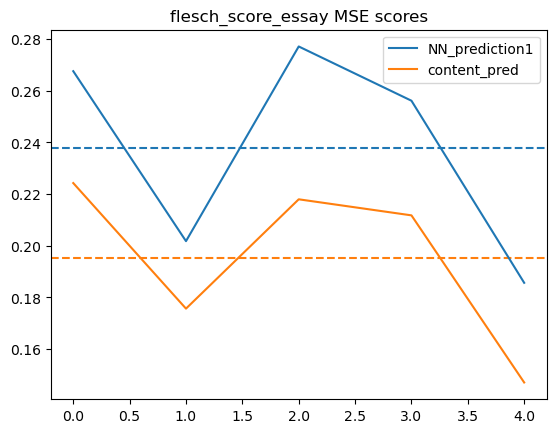

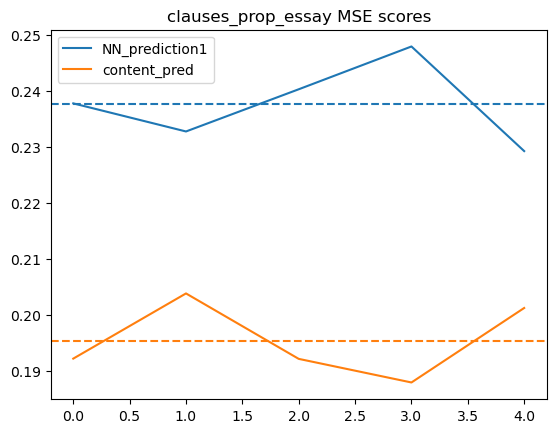

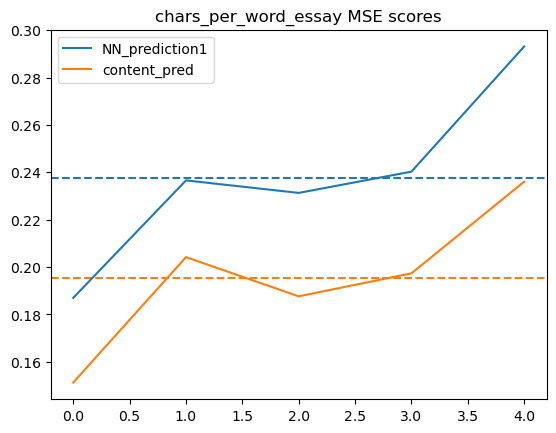

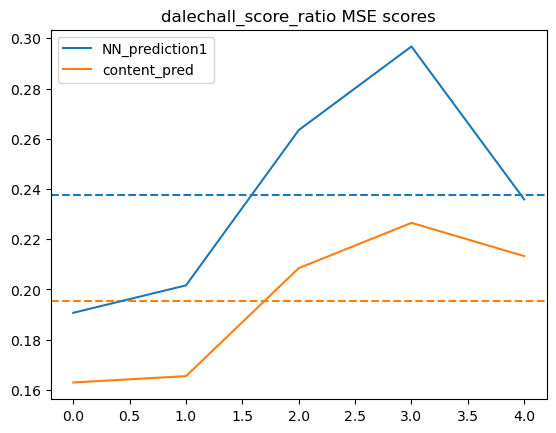

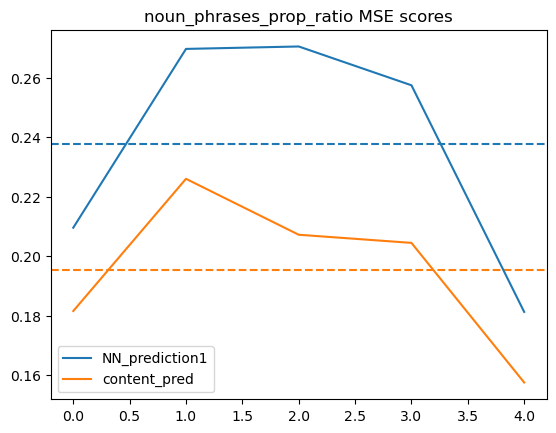

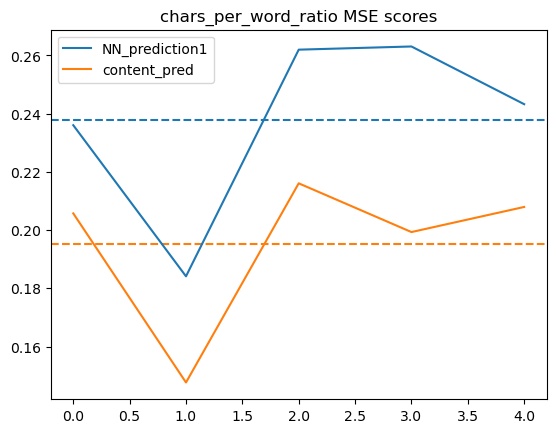

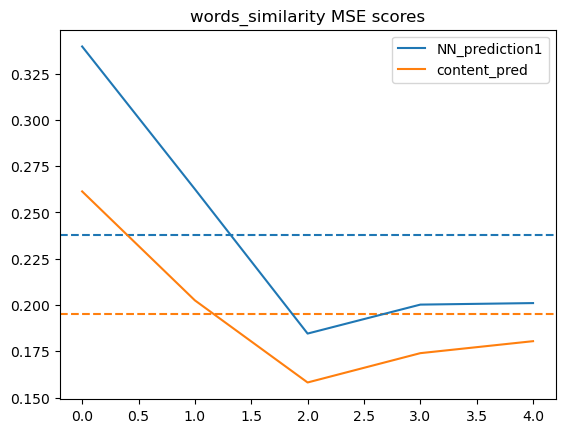

In [44]:
plot_predictions_comparisson(df_val, content_features, 'content', 'NN_prediction1', 'content_pred')

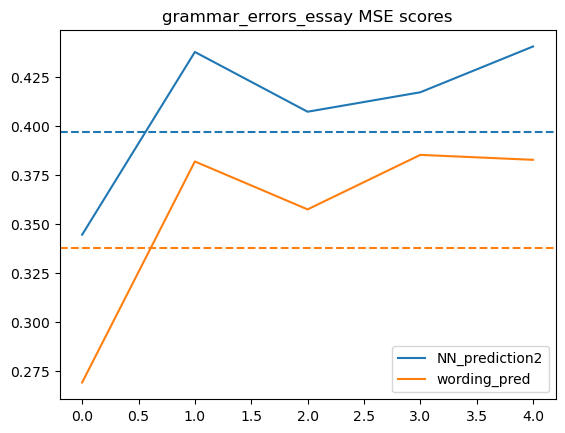

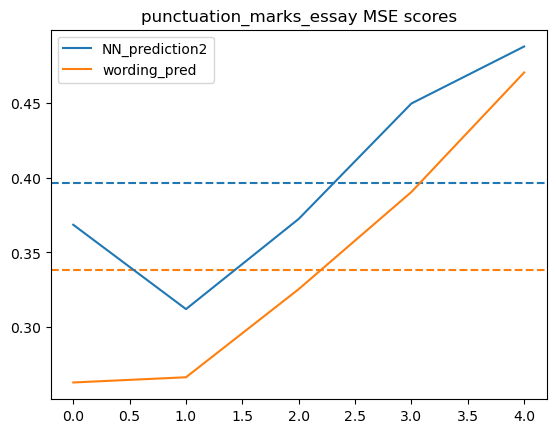

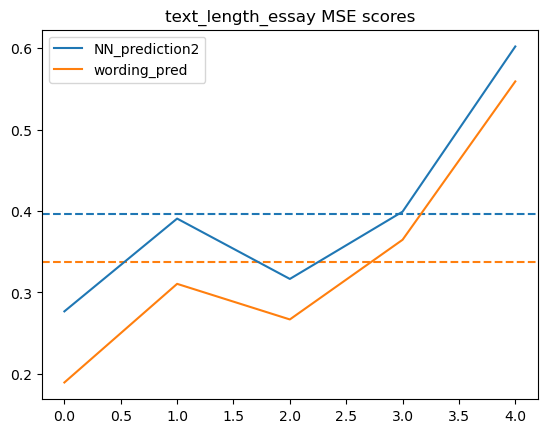

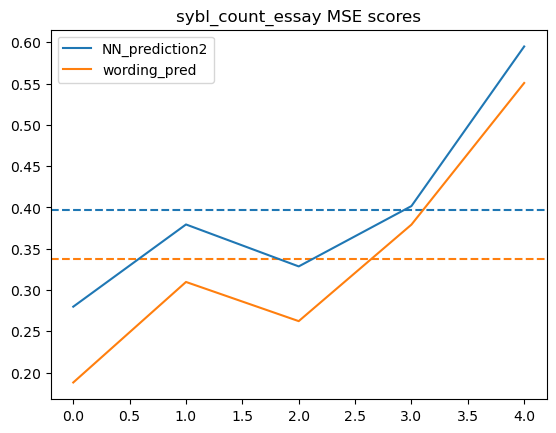

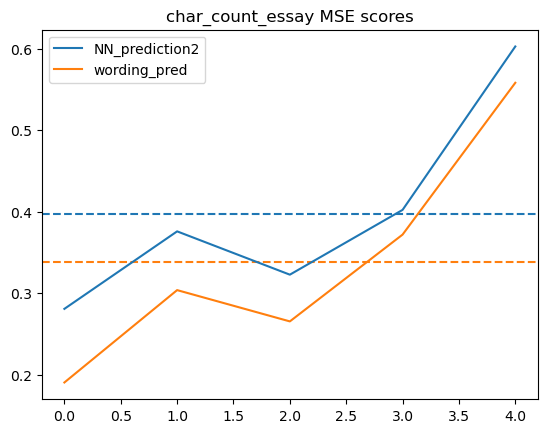

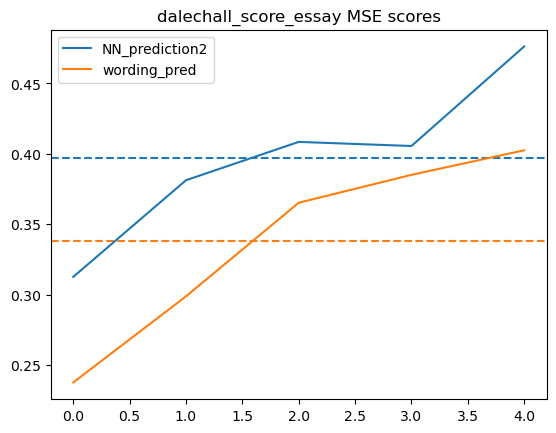

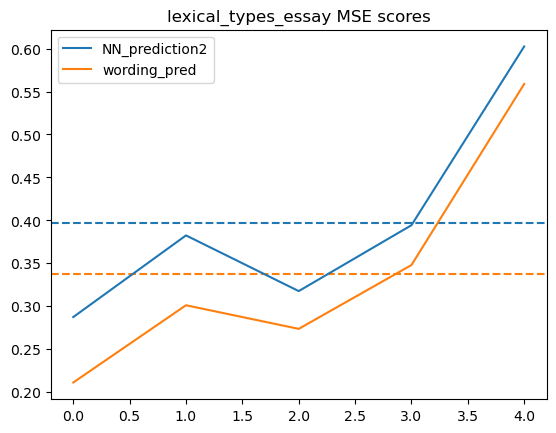

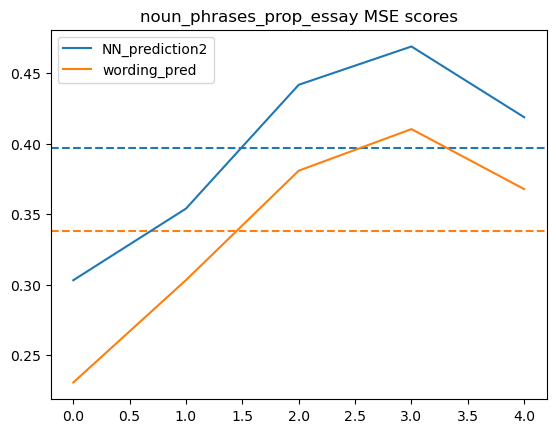

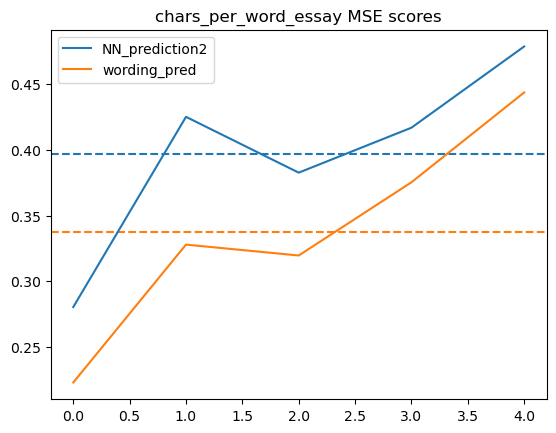

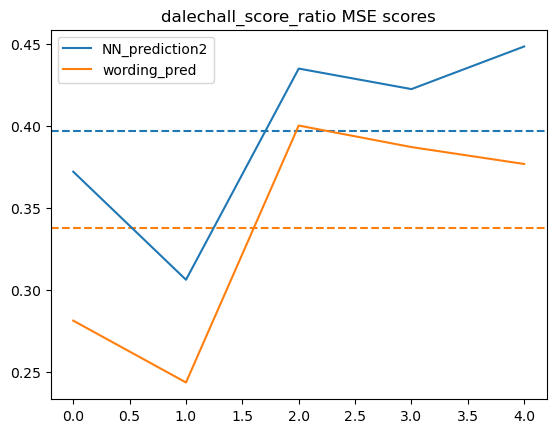

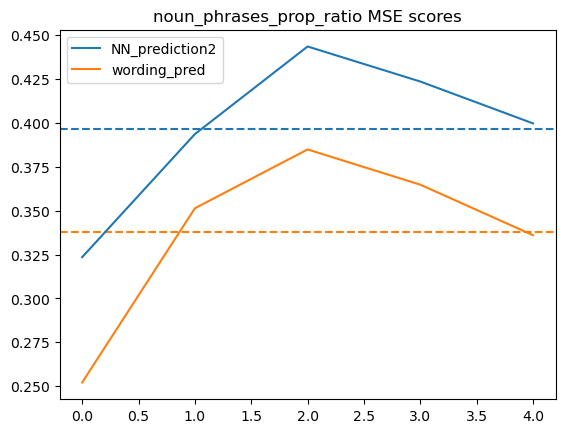

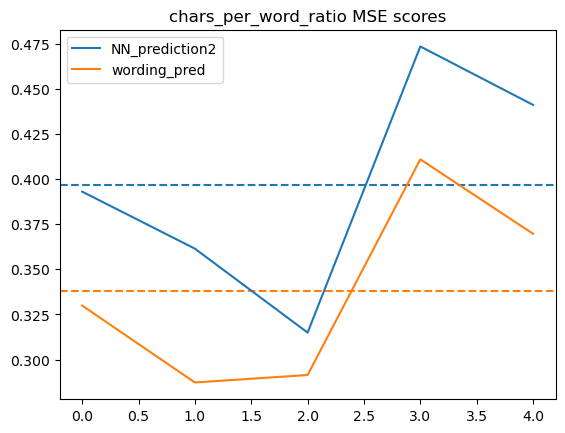

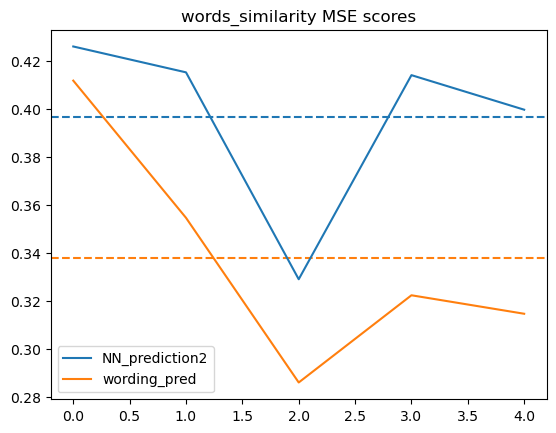

In [45]:
plot_predictions_comparisson(df_val, wording_features, 'wording', 'NN_prediction2', 'wording_pred')